# Machine Learning 3253 - Project Assignment



## Team Members
    
* Craig Barbisan
* Nisha Choondassery
* Mark Hubbard
* Itay Segal



## Project Overview

Using the "Movies Dataset"  from Kaggle, this project will create an optimal model for predicting a movie's rating.

## Notebook Overview

This notebook will explore the data, evaluate some models and draw conclusions.

It is divided into the following main sections:

1. Setup - seting up the Notebook environment.
2. Data - acquiring, exploring and processing the data.
3. Model - training and testing various models.
4. Analysis - analyzing the model results.
5. Summary - summarizing the observations and conclusions.

# 1.0 Setup

## Libraries

In [574]:
# import the basic libraries
import os
import numpy as np
import pandas as pd
import json
import ast
import tarfile

# make this notebook's output stable across runs
SEED = 42
np.random.seed(SEED)

# ensure full display for dataframe content
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('precision', 5)
pd.set_option('large_repr', 'truncate')
pd.set_option('display.max_colwidth', -1)
pd.set_option('colheader_justify', 'left')

# enable basic plots with pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# enable advanced plots
import seaborn as sns
sns.set(style='darkgrid')
sns.set(font_scale=1.2)

In [575]:
# import sklearn libraries

# pipeline processing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

# data splitting
from sklearn.model_selection import train_test_split

# classifier models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# model evaluation
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [576]:
# suppress warnings
import warnings
# warnings.filterwarnings('ignore')

## Common Functions

### Exploratory Data Analysis Functions

In [577]:
# function: basic schema analysis
def quick_schema_analysis(df):
    print("Basic Schema Analysis for dataframe=" + df.name)
    print("************************************************")
    
    print("Rows and Columns:")
    print(df.shape)
    print(df.info())
    print("\n")
    
    print("Null Values - percentage:")
    print((1 - df.count()/len(df.index)) * 100)
    print("\n")
    
    print("Null Values - count:")
    print(df.isnull().sum())
    print("\n")

In [578]:
# function: basic data analysus
def quick_data_analysis(df):
    print("Basic Data Analysis for dataframe=" + df.name)
    print(df.shape)

### Exploratory Data Analysis Plots

In [579]:
# function: plot a column vs column correlation map
def plot_data_correlation(data):
    sns.pairplot(data)

In [580]:
# function: plot a complete histogram for all columns
def plot_data_histograms(data):
    plt.figure()
    data.hist(bins=50, figsize=(20,15))
    plt.show()

In [581]:
# function: plot percentage/count of categoric feature values per target value
def plot_feature_vs_target(data, column_id, feature_name, target_name):

    plt.figure()
    plt.title(target_name + " by " + feature_name + " (Percent)")
    plt.xlabel(feature_name)
    ax = sns.barplot(x=column_id, y=column_id, data=data, estimator=lambda x: len(x) / len(data) * 100)
    ax.set(ylabel="Percent")
    plt.show()

    plt.figure()
    plt.title(target_name + " by " + feature_name + " (Count)")
    sns.countplot(x=column_id, hue=target_name, data=data, palette='RdBu')
    plt.show()

In [582]:
# function: plot a correlation heatmap
def plot_correlation(data):
    X = data.iloc[:,0:20]  #independent columns
    y = data.iloc[:,-1]    #target column i.e price range

    #get correlations of each features in dataset
    corrmat = data.corr()
    top_corr_features = corrmat.index
    plt.figure(figsize=(20,20))

    #plot heat map
    g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

### Model Evaluation Plots

#### Confusion Matrix Plots

In [583]:
# function: generate a confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

def generate_confusion_matrix(classifier, X, y, cv):
  
    # calculate the predicted values
    y_cvp = cross_val_predict(classifier, X, y, cv=cv)
    
    # calculate the confusion matrix
    cm = confusion_matrix(y, y_cvp)

    tn, fp, fn, tp = confusion_matrix(y, y_cvp).ravel()
    print("True  Negatives: {}".format(tn))
    print("False Positives: {}".format(fp))
    print("False Negatives: {}".format(fn))
    print("True  Positives: {}".format(tp))

    # plot the confusion matrix
    plot_confusion_matrix(cm, classes=[target_name_negative, 
                                       target_name_positive], 
                          normalize=False, title='Confusion Matrix')

In [584]:
# function: plot a confusion matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(7, 7))
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Confusion Matrix (with normalization)')
    else:
        print('Confusion Matrix (without normalization)')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

#### Precision Recall Plots

In [585]:
# function: generate the Precision-Recall curves
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score

def generate_precision_vs_recall(y, y_scores):

    precisions, recalls, thresholds = precision_recall_curve(y, y_scores)

    plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

    plot_precision_vs_recall(precisions, recalls)
  
    print(precision_score(y_train, clf_y_train_cvp))
    print(recall_score(y_train, clf_y_train_cvp))

In [586]:
# function: plot the precision-recall-threshold curve
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 4))
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='best')
    plt.ylim([0, 1])
    plt.grid(True)
    plt.show()

In [587]:
# function: plot the precision vs recall curve
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, 'b-', linewidth=2)
    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precision', fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.show()
    
    print("True  Negatives: {}".format(tn))
    print("False Positives: {}".format(fp))
    print("False Negatives: {}".format(fn))
    print("True  Positives: {}".format(tp))

#### ROC Plots

In [588]:
# function: generate ROC curve
def generate_roc_curve(classifier, X, y, cv):
  
    # calculate probabilities
    y_probability_score = calculate_probability_score(classifier, X, y, cv)
    
    fpr, tpr, thresholds = roc_curve(y, y_probability_score)
    
    # plot the ROC curve
    plt.title('ROC Curve')

    plot_roc_curve(fpr, tpr,'Best Classifier')

    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.legend(loc='lower right', fontsize=16)
    plt.show()
    
    print("AUC Score: {}".format(roc_auc_score(y, y_probability_score)))

In [589]:
# function: plot the ROC curve
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])   

In [590]:
# calculate probability score
from sklearn.model_selection import cross_val_predict

def calculate_probability_score(classifier, X, y, cv):

  clf_y_probas = cross_val_predict(classifier, X, y, cv=cv, 
                                         method="predict_proba")

  clf_y_scores = clf_y_probas[:, 1] # score = proba of positive class
  
  return clf_y_scores

### Model Scoring Functions

In [591]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())

### Data Functions

In [592]:
# class: DataFrameSelector transform (scikit doesn't support DataFrames yet)
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self.fit(X, y)
    def transform(self, X):
        return X[self.attribute_names].copy()
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [593]:
# function: download a file from Kaggle in chunks
import requests

USERNAME = 'username'
PASSWORD = 'password'

def download_from_Kaggle(remote_file, local_file):

    kaggle_info = {'UserName': USERNAME, 'Password': PASSWORD}

    r = requests.get(remote_file, auth=(USERNAME, PASSWORD))

    # r = requests.post(r.url, data = kaggle_info)
    
    print('here...')
    # read and write 512KB chunks at a time
    f = open(local_file, 'wb')
    for chunk in r.iter_content(chunk_size = 512 * 1024):
        if chunk:
            f.write(chunk)
            print('chunk')

    f.close()

In [594]:
# function: download an entire file from a public Web site
from urllib.request import urlretrieve

def download_from_Web(remote_file, local_file):
    urlretrieve(remote_file, local_file)

In [595]:
# function: download files from the internet and optionally unzip them
from zipfile import ZipFile

def fetch_data(url, file, local_path, zip=False):
    if not os.path.isdir(local_path):
        os.makedirs(local_path)
    
    remote_file = url
    local_file  = os.path.join(local_path, file)
   
    print(remote_file)
    
    if not os.path.isfile(local_file):
        print('Downloading ' + file + '...')
        
        download_from_Web(remote_file, local_file)

        print('Download complete.')
        
    else:
        print('Already downloaded.')

    if zip:
       unzip_file(local_file)


In [596]:
# function: unzip a file

def unzip_file(file):
 
    zip_path = file[:-4]
  
    if (os.path.isdir(zip_path)):
        print('Already extracted.')
    else:
        print('Extracting...')
        zfile = ZipFile(file, 'r')
        print(zfile.infolist())
        zfile.extractall(zip_path)
        zfile.close()
        print('Extraction complete.')

In [597]:
# convert json to abstract syntax trees (ast)

# use ast because json data has single quotes in the csvs
# which is invalid for a json object (should be double quotes)

def convert_json_to_ast(df, json_columns):
  
    for column in json_columns:
        df[column] = df[column].apply(lambda x: np.nan if pd.isnull(x)
                                                else ast.literal_eval(str(x)))

In [598]:
# convert the columns that contain the dictionary field with the name value in its ast 
def get_dict_val_from_ast(df,columns,field_name, fillna_str):
    for column in columns:
        df[column] = df[column].fillna(fillna_str) # first replace NaN with fillna_str
        df[column] = df[column].apply(lambda x: x[field_name] if isinstance(x, dict) else [])  #.apply(ast.literal_eval)

In [599]:
# convert the columns that contain the list field with the name value in its ast
def get_list_val_from_ast(df,columns,field_name, fillna_str=None, new_col_dict=None):
    for column in columns:
        if(fillna_str):
            df[column] = df[column].fillna(fillna_str) # first replace NaN with fillna_str
        new_column = column
        if(new_col_dict and column in new_col_dict):
            new_column = new_col_dict[column]
        df[new_column] = df[column].apply(lambda x: [i[field_name] for i in x] if isinstance(x, list) else [])  #.apply(ast.literal_eval)

In [600]:
# convert to float
def cast_to_float(df, columns,d_cast=None):
    for column in columns:
        if(d_cast):
            df[column] = pd.to_numeric(df[column],errors='coerce',downcast=d_cast)
        else:
            df[column] = pd.to_numeric(df[column],errors='coerce')
                

In [601]:
# fill in empty values with mean
def replace_empty_with_mean(df, columns):
    for column in columns:
        df[column] = df[column].fillna(df[column].mean())

In [602]:
# review column results after data cleansing

def assess_column(df, column, categories=False):
    print(df[column].head(10))
    print('Number of null entries: ', df[column].isnull().sum())
    if categories:
      print(df[column].unique())

In [603]:
# display column stats
def column_stats(df,feature):
    print('Total count is {}'.format(len(df[feature].value_counts())))
    print(df[feature].value_counts())

In [604]:
from urllib.parse import urlparse

# get domain from url
def get_url_domain(url):
    if(not pd.isnull(url)):
        parsed_uri = urlparse(url )
        return '{uri.netloc}'.format(uri=parsed_uri)
    else:
        return url

In [605]:
# list all unique values in a categorical column

# 2.0 Data 

## Data Acquisition

The dataset for this project is sourced from https://www.kaggle.com/rounakbanik/the-movies-dataset.

Credit: Rounak Banik

This dataset is an ensemble of data collected from TMDB and GroupLens.
* The Movie Details (i.e. Metadata), Credits and Keywords have been collected from the TMDB Open API.
* The Movie Links and Ratings have been obtained from the Official GroupLens website.

The following spreadsheets are used by this project:

* __movies_metadata.csv__: The main Movies Metadata file. Contains information on 45,000 movies featured in the Full MovieLens dataset. Features include posters, backdrops, budget, revenue, release dates, languages, production countries and companies.

* __credits.csv__: Consists of Cast and Crew Information for all our movies. Available in the form of a stringified JSON Object.

* __keywords.csv__:  Contains the movie plot keywords for our MovieLens movies. Available in the form of a stringified JSON Object.

* __links.csv__: The file that contains the TMDB and IMDB IDs of all the movies featured in the Full MovieLens dataset.

* __ratings_small.csv__: The subset of 100,000 ratings from 700 users on 9,000 movies.

The Full MovieLens Dataset consisting of 26 million ratings and 750,000 tag applications from 270,000 users on all the 45,000 movies in this dataset can be accessed at https://grouplens.org/datasets/movielens/latest/

The dataset for this project is stored as a public file on Dropbox:
https://www.dropbox.com/s/89uv5kntgiolkno/the-movies-dataset.zip?dl=1

(Kaggle requires multiple manual steps by the notebook user and Google Drive injects a virus detection warning  page for downloads of large files).

In [606]:
# specify file names and locations
URL_DOMAIN    = 'https://www.dropbox.com'
URL_PATH      = '/s/89uv5kntgiolkno/the-movies-dataset.zip?dl=1'

G_URL_DOMAIN  = 'https://drive.google.com'
G_URL_PATH    = '/uc?export=download&confirm=no_antivirus&id=16zqahjyBrcdJYKBMK-zo2NbRHyyNHVQJ'

K_URL_DOMAIN2 = 'http://www.kaggle.com'
K_URL_PATH    = '/rounakbanik/the-movies-dataset/downloads/'

PROJECT_LOCAL_DIR  = 'movies/'
PROJECT_OUTPUT_DIR = '/content/movies/output'
PROJECT_FILE       = 'the-movies-dataset.zip'

In [607]:
# download the dataset file

url = URL_DOMAIN + URL_PATH

fetch_data(url, PROJECT_FILE, PROJECT_LOCAL_DIR, zip=True)

https://www.dropbox.com/s/89uv5kntgiolkno/the-movies-dataset.zip?dl=1
Already downloaded.
Already extracted.


In [608]:
# download the text parsing file

url = URL_DOMAIN + '/s/svv8312fd9e7e9k/stopwords.txt?dl=1'

fetch_data(url, 'stopwords.txt', 'movies/resources', zip=False)

https://www.dropbox.com/s/svv8312fd9e7e9k/stopwords.txt?dl=1
Already downloaded.


Create dataframes for each of the spreadsheets.

As part of loading the dataframes, convert null values to NaN on the fly (via pd.read_csv).

By default the following values are interpreted as NaN: ‘’, ‘#N/A’, ‘#N/A N/A’, ‘#NA’, ‘-1.#IND’, ‘-1.#QNAN’, ‘-NaN’, ‘-nan’, ‘1.#IND’, ‘1.#QNAN’, ‘N/A’, ‘NA’, ‘NULL’, ‘NaN’, ‘n/a’, ‘nan’, ‘null’.

In [609]:
# initialize the dataframes (and convert null fields on the fly)

zip_path = os.path.join(PROJECT_LOCAL_DIR, PROJECT_FILE[:-4])


metadata_file = os.path.join(zip_path, 'movies_metadata.csv')
credits_file  = os.path.join(zip_path, 'credits.csv')
plot_file     = os.path.join(zip_path, 'keywords.csv')
links_file    = os.path.join(zip_path, 'links.csv')
ratings_file  = os.path.join(zip_path, 'ratings_small.csv')

# load the metadata dataframe

metadata = pd.read_csv(metadata_file,
                     dtype = 'unicode',
                     na_values = ['no info', '.']
                    )

# load the credits dataframe

credits = pd.read_csv(credits_file,
                      dtype = 'unicode',
                      na_values = ['no info', '.']
                     )

# load the plot dataframe

plot =  pd.read_csv(plot_file,
                    dtype = 'unicode',
                    na_values = ['no info', '.']
                   )

# load the links dataframe

links =  pd.read_csv(links_file,
                    dtype = 'unicode',
                    na_values = ['no info', '.']
                   )

# load the ratings dataframe

ratings = pd.read_csv(ratings_file,
                      dtype = 'unicode',
                      na_values = ['no info', '.']
                     )

dataframes = [metadata, credits, plot, links, ratings]

## Exploratory Data Analysis (EDA)

In [610]:
# make copies of data for EDA

metadata_copy = metadata.copy()
metadata_copy.name = 'metadata'

credits_copy = credits.copy()
credits_copy.name = 'credit'

plot_copy = plot.copy()
plot_copy.name = 'plot'

links_copy = links.copy()
links_copy.name = 'links'



eda_dataframes = [metadata_copy,
                  credits_copy,
                  plot_copy,
                  links_copy
                  
                 ]


### Explore the "metadata" data

__Features__

* __adult__: Indicates if the movie is X-Rated or Adult.
* __belongs_to_collection__: A stringified dictionary that gives information on the movie series the particular film belongs to.
* __budget__: The budget of the movie in dollars.
* __genres__: A stringified list of dictionaries that list out all the genres associated with the movie.
* __homepage__: The Official Homepage of the move.
* __id__: The ID of the movie.
* __imdb_id__: The IMDB ID of the movie.
* __original_language__: The language in which the movie was originally shot in.
* __original_title__: The original title of the movie.
* __overview__: A brief blurb of the movie.
* __popularity__: The Popularity Score assigned by TMDB.
* __poster_path__: The URL of the poster image.
* __production_companies__: A stringified list of production companies involved with the making of the movie.
* __production_countries__: A stringified list of countries where the movie was shot/produced in.
* __release_date__: Theatrical Release Date of the movie.
* __revenue__: The total revenue of the movie in dollars.
* __runtime__: The runtime of the movie in minutes.
* __spoken_languages__: A stringified list of spoken languages in the film.
* __status__: The status of the movie (Released, To Be Released, Announced, etc.)
* __tagline__: The tagline of the movie.
* __title__: The Official Title of the movie.
* __video__: Indicates if there is a video present of the movie with TMDB.
* __vote_average__: The average rating of the movie.
* __vote_count__: The number of votes by users, as counted by TMDB.

In [611]:
# quick review of the metadata data
quick_schema_analysis(metadata_copy)
quick_data_analysis(metadata_copy)

metadata_copy.head(5)

Basic Schema Analysis for dataframe=metadata
************************************************
Rows and Columns:
(45466, 24)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
adult                    45466 non-null object
belongs_to_collection    4494 non-null object
budget                   45466 non-null object
genres                   45466 non-null object
homepage                 7782 non-null object
id                       45466 non-null object
imdb_id                  45449 non-null object
original_language        45455 non-null object
original_title           45466 non-null object
overview                 44512 non-null object
popularity               45461 non-null object
poster_path              45080 non-null object
production_companies     45463 non-null object
production_countries     45463 non-null object
release_date             45379 non-null object
revenue                  45460 non-null object
runtime          

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', 'poster_path': '/7G9915LfUQ2lVfwMEEhDsn3kT4B.jpg', 'backdrop_path': '/9FBwqcd9IRruEDUrTdcaafOMKUq.jpg'}",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",1995-10-30,373554033,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, 'name': 'Fantasy'}, {'id': 10751, 'name': 'Family'}]",NaN,8844,tt0113497,en,Jumanji,"When siblings Judy and Peter discover an enchanted board game that opens the door to a magical world, they unwittingly invite Alan -- an adult who's been trapped inside the game for 26 years -- into their living room. Alan's only hope for freedom is to finish the game, which proves risky as all three find themselves running from giant rhinoceroses, evil monkeys and other terrifying creatures.",17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'name': 'Teitler Film', 'id': 2550}, {'name': 'Interscope Communications', 'id': 10201}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",1995-12-15,262797249,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'fr', 'name': 'Français'}]",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collection', 'poster_path': '/nLvUdqgPgm3F85NMCii9gVFUcet.jpg', 'backdrop_path': '/hypTnLot2z8wpFS7qwsQHW1uV8u.jpg'}",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, 'name': 'Comedy'}]",NaN,15602,tt0113228,en,Grumpier Old Men,"A family wedding reignites the ancient feud between next-door neighbors and fishing buddies John and Max. Meanwhile, a sultry Italian divorcée opens a restaurant at the local bait shop, alarming the locals who worry she'll scare the fish away. But she's less interested in seafood than she is in cooking up a hot time with Max.",11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name': 'Lancaster Gate', 'id': 19464}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",1995-12-22,0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for Love.,Grumpier Old Men,False,6.5,92
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the women are holding their breath, waiting for the elusive ""good man"" to break a string of less-than-stellar lovers. Friends and confidants Vannah, Bernie, Glo and Robin talk it all out, determined to find a better way to breathe.",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,"[{'name': 'Twentieth Century Fox Film Corporation', 'id': 306}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",1995-12-22,81452156,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself... and never let you forget it.,Waiting to Exhale,False,6.1,34
4,False,"{'id': 96871, 'name': 'Father of the Bride Collection', 'poster_path': '/nts4iOmNnq7GNicycMJ9pSAn204.jpg', 'backdrop_path

In [612]:
# check if there are any duplicates

print(metadata_copy.shape)
print(metadata_copy.drop_duplicates().shape)

(45466, 24)
(45449, 24)


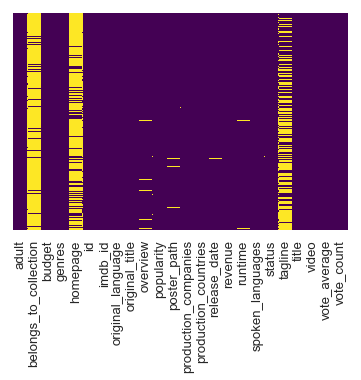

In [613]:
# plot a heatmap of nulls
sns.heatmap(metadata_copy.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')

### Explore the "credits" data

In [614]:
# quick review of the credits data

quick_schema_analysis(credits_copy)
quick_data_analysis(credits_copy)

credits_copy.head(3)

Basic Schema Analysis for dataframe=credit
************************************************
Rows and Columns:
(45476, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45476 entries, 0 to 45475
Data columns (total 3 columns):
cast    45476 non-null object
crew    45476 non-null object
id      45476 non-null object
dtypes: object(3)
memory usage: 1.0+ MB
None


Null Values - percentage:
cast    0.0
crew    0.0
id      0.0
dtype: float64


Null Values - count:
cast    0
crew    0
id      0
dtype: int64


Basic Data Analysis for dataframe=credit
(45476, 3)


cast                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

### Explore the "plot" data

In [615]:
# quick review of the plot data

quick_schema_analysis(plot_copy)
quick_data_analysis(plot_copy)

plot_copy.head(5)

Basic Schema Analysis for dataframe=plot
************************************************
Rows and Columns:
(46419, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46419 entries, 0 to 46418
Data columns (total 2 columns):
id          46419 non-null object
keywords    46419 non-null object
dtypes: object(2)
memory usage: 725.4+ KB
None


Null Values - percentage:
id          0.0
keywords    0.0
dtype: float64


Null Values - count:
id          0
keywords    0
dtype: int64


Basic Data Analysis for dataframe=plot
(46419, 2)


,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290, 'name': 'toy'}, {'id': 5202, 'name': 'boy'}, {'id': 6054, 'name': 'friendship'}, {'id': 9713, 'name': 'friends'}, {'id': 9823, 'name': 'rivalry'}, {'id': 165503, 'name': 'boy next door'}, {'id': 170722, 'name': 'new toy'}, {'id': 187065, 'name': 'toy comes to life'}]"
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 10941, 'name': 'disappearance'}, {'id': 15101, 'name': ""based on children's book""}, {'id': 33467, 'name': 'new home'}, {'id': 158086, 'name': 'recluse'}, {'id': 158091, 'name': 'giant insect'}]"
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392, 'name': 'best friend'}, {'id': 179431, 'name': 'duringcreditsstinger'}, {'id': 208510, 'name': 'old men'}]"
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id': 10131, 'name': 'interracial relationship'}, {'id': 14768, 'name': 'single mother'}, {'id': 15160, 'name': 'divorce'}, {'id': 33455, 'name': 'chick flick'}]"
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'name': 'midlife crisis'}, {'id': 2246, 'name': 'confidence'}, {'id': 4995, 'name': 'aging'}, {'id': 5600, 'name': 'daughter'}, {'id': 10707, 'name': 'mother daughter relationship'}, {'id': 13149, 'name': 'pregnancy'}, {'id': 33358, 'name': 'contraception'}, {'id': 170521, 'name': 'gynecologist'}]"


### Explore the links data

In [616]:
# quick review of the links data

quick_schema_analysis(links_copy)
quick_data_analysis(links_copy)

links_copy.head(5)

Basic Schema Analysis for dataframe=links
************************************************
Rows and Columns:
(45843, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45843 entries, 0 to 45842
Data columns (total 3 columns):
movieId    45843 non-null object
imdbId     45843 non-null object
tmdbId     45624 non-null object
dtypes: object(3)
memory usage: 1.0+ MB
None


Null Values - percentage:
movieId    0.00000
imdbId     0.00000
tmdbId     0.47772
dtype: float64


Null Values - count:
movieId    0  
imdbId     0  
tmdbId     219
dtype: int64


Basic Data Analysis for dataframe=links
(45843, 3)


,movieId,imdbId,tmdbId
0,1,0114709,862
1,2,0113497,8844
2,3,0113228,15602
3,4,0114885,31357
4,5,0113041,11862


## Data Cleansing

### Clean the metadata data

In [617]:
metadata.head(1)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', 'poster_path': '/7G9915LfUQ2lVfwMEEhDsn3kT4B.jpg', 'backdrop_path': '/9FBwqcd9IRruEDUrTdcaafOMKUq.jpg'}",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",1995-10-30,373554033,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415


In [618]:
metadata['id'].isnull().sum()

0

Perform the following type conversions:
* Convert __release_date__ to datetime
* Convert __budget__ and __revenue__ to numerics
* Convert all JSON fields to abstract syntax trees
* Convert __vote_average__ to float
* Convert __vote_count__ to integer

In [619]:
# convert each item of release_date to a datetime type entity

metadata['release_date'] = pd.to_datetime(metadata['release_date'],
                                          errors='coerce')

# metadata['release_date'] = metadata['release_date'].fillna('?')

In [620]:
assess_column(metadata, 'release_date')

0   1995-10-30
1   1995-12-15
2   1995-12-22
3   1995-12-22
4   1995-02-10
5   1995-12-15
6   1995-12-15
7   1995-12-22
8   1995-12-22
9   1995-11-16
Name: release_date, dtype: datetime64[ns]
Number of null entries:  90


In [621]:
# convert budget and revenue fields to be numeric
# (...and convert 0 to a NaN to enable budget and revenue math)

metadata['budget']  = pd.to_numeric(metadata['budget'],  errors='coerce')
metadata['revenue'] = pd.to_numeric(metadata['revenue'], errors='coerce')

metadata['budget']  = metadata['budget'].replace(0, np.nan)
metadata['revenue'] = metadata['revenue'].replace(0, np.nan)

In [622]:
assess_column(metadata, 'budget')
assess_column(metadata, 'revenue')

0    30000000.0
1    65000000.0
2   NaN        
3    16000000.0
4   NaN        
5    60000000.0
6    58000000.0
7   NaN        
8    35000000.0
9    58000000.0
Name: budget, dtype: float64
Number of null entries:  36576
0    3.73554e+08
1    2.62797e+08
2   NaN         
3    8.14522e+07
4    7.65789e+07
5    1.87437e+08
6   NaN         
7   NaN         
8    6.43502e+07
9    3.52194e+08
Name: revenue, dtype: float64
Number of null entries:  38058


In [623]:
# convert json columns to abstract syntax trees

json_columns = ['belongs_to_collection',
                'genres',
                'production_companies',
                'production_countries',
                'spoken_languages'
               ]

convert_json_to_ast(metadata, json_columns)

In [624]:
# def get_val_from_ast(df,columns,field_name)
get_dict_val_from_ast(metadata, ['belongs_to_collection'],'name','')

In [625]:
assess_column(metadata, 'belongs_to_collection')

0    Toy Story Collection          
1    []                            
2    Grumpy Old Men Collection     
3    []                            
4    Father of the Bride Collection
5    []                            
6    []                            
7    []                            
8    []                            
9    James Bond Collection         
Name: belongs_to_collection, dtype: object
Number of null entries:  0


In [626]:
get_list_val_from_ast(metadata, ['genres'],'name','Other')

In [627]:
assess_column(metadata, 'genres')

0    [Animation, Comedy, Family]       
1    [Adventure, Fantasy, Family]      
2    [Romance, Comedy]                 
3    [Comedy, Drama, Romance]          
4    [Comedy]                          
5    [Action, Crime, Drama, Thriller]  
6    [Comedy, Romance]                 
7    [Action, Adventure, Drama, Family]
8    [Action, Adventure, Thriller]     
9    [Adventure, Action, Thriller]     
Name: genres, dtype: object
Number of null entries:  0


In [628]:
get_list_val_from_ast(metadata, ['production_companies'],'name','')

In [629]:
assess_column(metadata, 'production_companies')

0    [Pixar Animation Studios]                                                                                                                                      
1    [TriStar Pictures, Teitler Film, Interscope Communications]                                                                                                    
2    [Warner Bros., Lancaster Gate]                                                                                                                                 
3    [Twentieth Century Fox Film Corporation]                                                                                                                       
4    [Sandollar Productions, Touchstone Pictures]                                                                                                                   
5    [Regency Enterprises, Forward Pass, Warner Bros.]                                                                                                              
6    [Para

In [630]:
get_list_val_from_ast(metadata, ['production_countries'],'iso_3166_1','Other')

In [631]:
assess_column(metadata, 'production_countries')

0    [US]    
1    [US]    
2    [US]    
3    [US]    
4    [US]    
5    [US]    
6    [DE, US]
7    [US]    
8    [US]    
9    [GB, US]
Name: production_countries, dtype: object
Number of null entries:  0


In [632]:
cast_to_float(metadata, ['runtime'])

In [633]:
# replaced by the previous cell
# convert runtime to float

metadata['runtime'] = pd.to_numeric(metadata['runtime'],
                                       errors='coerce'
                                      )

In [634]:
assess_column(metadata, 'runtime')

0    81.0 
1    104.0
2    101.0
3    127.0
4    106.0
5    170.0
6    127.0
7    97.0 
8    106.0
9    130.0
Name: runtime, dtype: float64
Number of null entries:  263


In [635]:
get_list_val_from_ast(metadata, ['spoken_languages'],'name','Other')

In [636]:
assess_column(metadata, 'spoken_languages')

0    [English]                  
1    [English, Français]        
2    [English]                  
3    [English]                  
4    [English]                  
5    [English, Español]         
6    [Français, English]        
7    [English, Deutsch]         
8    [English]                  
9    [English, Pусский, Español]
Name: spoken_languages, dtype: object
Number of null entries:  0


In [637]:
cast_to_float(metadata, ['vote_average'])

replace_empty_with_mean(metadata, ['vote_average'])

In [638]:
assess_column(metadata, 'vote_average')

0    7.7
1    6.9
2    6.5
3    6.1
4    5.7
5    7.7
6    6.2
7    5.4
8    5.5
9    6.6
Name: vote_average, dtype: float64
Number of null entries:  0


In [639]:
cast_to_float(metadata, ['vote_count'],'integer')

In [640]:
metadata['vote_count'] = metadata['vote_count'].fillna(0)

In [641]:
assess_column(metadata, 'vote_count')

0    5415.0
1    2413.0
2    92.0  
3    34.0  
4    173.0 
5    1886.0
6    141.0 
7    45.0  
8    174.0 
9    1194.0
Name: vote_count, dtype: float64
Number of null entries:  0


### Clean the credits data

In [642]:
credits.head(1)

cast                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       \
0  [{'cast_id': 14, 'character': 'Woody (voice)', 'credit_id': '52fe4284c3a36847f8024f95', 'gender': 2, 'id': 31, 'name': 'Tom Hanks', 'order': 0, 'profile_path': '/pQFoyx7rp09CJTAb932F2g8Nlho.jpg'}, {'cast_id': 15, 'character': 'Buzz Lightyear (voice)', 'credit_id': '52fe4284c3a36847f8024f99', 'gender': 2, 'id': 12898, 'name': 'Tim Allen', 'order': 1, 'profile_path': '/uX2xVf6pMmPepxnvFWyBtjexzgY.jpg'}, {'cast_id': 16, 'character': 'Mr. Potato Head (voice)', 'credit_id': '52fe4284c3a36847f8024f9d', 'gender': 2, 'id': 7167, 'name': 'Don Rickles', 'order': 2, 'profile_path': '/h5BcaDMPRVLHLDzbQavec4xfSdt.jpg'}, {'cast_id': 17, 'character': 'Slinky Dog (voice)', 'credit_id': '52fe4284c3a36847f8024fa1', 'gender': 2, 'id': 12899, 'name': 'Jim Varney', 'order': 3, 'profile_path': '/eIo2jVVXYgjDtaHoF19Ll9vtW7h.jpg'}, {'cast_id': 18, 'character': 'Rex (voice)', 'credit_id': '52fe4284c3a36847f8024fa5', 'gender': 2, 'id': 12900, 'name': 'Wallace Shawn', 'order': 4, 'profile_path': '/oGE6JqPP2xH4tNORKNqxbNPYi7u.jpg'}, {'cast_id': 19, 'character': 'Hamm (voice)', 'credit_id': '52fe4284c3a36847f8024fa9', 'gender': 2, 'id': 7907, 'name': 'John Ratzenberger', 'order': 5, 'profile_path': '/yGechiKWL6TJDfVE2KPSJYqdMsY.jpg'}, {'cast_id': 20, 'character': 'Bo Peep (voice)', 'credit_id': '52fe4284c3a36847f8024fad', 'gender': 1, 'id': 8873, 'name': 'Annie Potts

In [643]:
# convert json columns to abstract syntax trees

json_columns = ['cast', 'crew']
    
convert_json_to_ast(credits, json_columns)

In [644]:
# populate cast and crew with string extractions from their current ast

credits['cast'] = (credits['cast'].fillna('')
#                                 .apply(ast.literal_eval)
                  )
 
credits['crew'] = (credits['crew'].fillna('')
#                                 .apply(ast.literal_eval)
                  )

In [645]:
assess_column(credits, 'cast')
assess_column(credits, 'crew')

0    [{'cast_id': 14, 'character': 'Woody (voice)', 'credit_id': '52fe4284c3a36847f8024f95', 'gender': 2, 'id': 31, 'name': 'Tom Hanks', 'order': 0, 'profile_path': '/pQFoyx7rp09CJTAb932F2g8Nlho.jpg'}, {'cast_id': 15, 'character': 'Buzz Lightyear (voice)', 'credit_id': '52fe4284c3a36847f8024f99', 'gender': 2, 'id': 12898, 'name': 'Tim Allen', 'order': 1, 'profile_path': '/uX2xVf6pMmPepxnvFWyBtjexzgY.jpg'}, {'cast_id': 16, 'character': 'Mr. Potato Head (voice)', 'credit_id': '52fe4284c3a36847f8024f9d', 'gender': 2, 'id': 7167, 'name': 'Don Rickles', 'order': 2, 'profile_path': '/h5BcaDMPRVLHLDzbQavec4xfSdt.jpg'}, {'cast_id': 17, 'character': 'Slinky Dog (voice)', 'credit_id': '52fe4284c3a36847f8024fa1', 'gender': 2, 'id': 12899, 'name': 'Jim Varney', 'order': 3, 'profile_path': '/eIo2jVVXYgjDtaHoF19Ll9vtW7h.jpg'}, {'cast_id': 18, 'character': 'Rex (voice)', 'credit_id': '52fe4284c3a36847f8024fa5', 'gender': 2, 'id': 12900, 'name': 'Wallace Shawn', 'order': 4, 'profile_path': '/oGE6JqPP2

### Clean the plot data

In [646]:
plot.head(1)

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290, 'name': 'toy'}, {'id': 5202, 'name': 'boy'}, {'id': 6054, 'name': 'friendship'}, {'id': 9713, 'name': 'friends'}, {'id': 9823, 'name': 'rivalry'}, {'id': 165503, 'name': 'boy next door'}, {'id': 170722, 'name': 'new toy'}, {'id': 187065, 'name': 'toy comes to life'}]"


In [647]:
# convert json columns to abstract syntax trees

json_columns = ['keywords']

convert_json_to_ast(plot, json_columns)

In [648]:
get_list_val_from_ast(plot, ['keywords'],'name','')

In [649]:
assess_column(plot, 'keywords')

0    [jealousy, toy, boy, friendship, friends, rivalry, boy next door, new toy, toy comes to life]                                                                                                                                                           
1    [board game, disappearance, based on children's book, new home, recluse, giant insect]                                                                                                                                                                  
2    [fishing, best friend, duringcreditsstinger, old men]                                                                                                                                                                                                   
3    [based on novel, interracial relationship, single mother, divorce, chick flick]                                                                                                                                                          

## Data Merge

In [650]:
# compare the shapes of all the dataframes

print(metadata.shape)
print(credits.shape)
print(plot.shape)
print(links.shape)



(45466, 24)
(45476, 3)
(46419, 2)
(45843, 3)


In [651]:
# initialize the merged dataframe "movies"
movies = metadata.copy()
print(movies.shape)

(45466, 24)


### Merge metadata and credit 

In [652]:
# perform a left join of credits to movies (adds 4 columns)
movies = movies.merge(credits, on=["id"])
print(movies.shape)

(45538, 26)


In [653]:
movies.drop(['crew','cast'],axis=1).head(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,Toy Story Collection,30000000.0,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,[Pixar Animation Studios],[US],1995-10-30,3.73554e+08,81.0,[English],Released,NaN,Toy Story,False,7.7,5415.0
1,False,[],65000000.0,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,"When siblings Judy and Peter discover an enchanted board game that opens the door to a magical world, they unwittingly invite Alan -- an adult who's been trapped inside the game for 26 years -- into their living room. Alan's only hope for freedom is to finish the game, which proves risky as all three find themselves running from giant rhinoceroses, evil monkeys and other terrifying creatures.",17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[TriStar Pictures, Teitler Film, Interscope Communications]",[US],1995-12-15,2.62797e+08,104.0,"[English, Français]",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,Grumpy Old Men Collection,NaN,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,"A family wedding reignites the ancient feud between next-door neighbors and fishing buddies John and Max. Meanwhile, a sultry Italian divorcée opens a restaurant at the local bait shop, alarming the locals who worry she'll scare the fish away. But she's less interested in seafood than she is in cooking up a hot time with Max.",11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[Warner Bros., Lancaster Gate]",[US],1995-12-22,NaN,101.0,[English],Released,Still Yelling. Still Fighting. Still Ready for Love.,Grumpier Old Men,False,6.5,92.0
3,False,[],16000000.0,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the women are holding their breath, waiting for the elusive ""good man"" to break a string of less-than-stellar lovers. Friends and confidants Vannah, Bernie, Glo and Robin talk it all out, determined to find a better way to breathe.",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[Twentieth Century Fox Film Corporation],[US],1995-12-22,8.14522e+07,127.0,[English],Released,Friends are the people who let you be yourself... and never let you forget it.,Waiting to Exhale,False,6.1,34.0
4,False,Father of the Bride Collection,NaN,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,"Just when George Banks has recovered from his daughter's wedding, he receives the news that she's pregnant ... and that George's wife, Nina, is expecting too. He was planning on selling their home, but that's a plan that -- like George -- will have to change with the arrival of both a grandchild and a kid of his own.",8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[Sandollar Productions, Touchstone Pictures]",[US],1995-02-10,7.65789e+07,106.0,[English],Released,Just When His World Is Back To Normal... He's In For The Surprise Of His Life!,Father of the Bride Part II,False,5.7,173.0


### Merge plot

In [654]:
movies = movies.merge(plot, on=['id'])
print(movies.shape)

(46628, 27)


In [655]:
movies.drop(['crew','cast'],axis=1).head(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,keywords
0,False,Toy Story Collection,30000000.0,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,[Pixar Animation Studios],[US],1995-10-30,3.73554e+08,81.0,[English],Released,NaN,Toy Story,False,7.7,5415.0,"[jealousy, toy, boy, friendship, friends, rivalry, boy next door, new toy, toy comes to life]"
1,False,[],65000000.0,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,"When siblings Judy and Peter discover an enchanted board game that opens the door to a magical world, they unwittingly invite Alan -- an adult who's been trapped inside the game for 26 years -- into their living room. Alan's only hope for freedom is to finish the game, which proves risky as all three find themselves running from giant rhinoceroses, evil monkeys and other terrifying creatures.",17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[TriStar Pictures, Teitler Film, Interscope Communications]",[US],1995-12-15,2.62797e+08,104.0,"[English, Français]",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[board game, disappearance, based on children's book, new home, recluse, giant insect]"
2,False,Grumpy Old Men Collection,NaN,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,"A family wedding reignites the ancient feud between next-door neighbors and fishing buddies John and Max. Meanwhile, a sultry Italian divorcée opens a restaurant at the local bait shop, alarming the locals who worry she'll scare the fish away. But she's less interested in seafood than she is in cooking up a hot time with Max.",11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[Warner Bros., Lancaster Gate]",[US],1995-12-22,NaN,101.0,[English],Released,Still Yelling. Still Fighting. Still Ready for Love.,Grumpier Old Men,False,6.5,92.0,"[fishing, best friend, duringcreditsstinger, old men]"
3,False,[],16000000.0,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the women are holding their breath, waiting for the elusive ""good man"" to break a string of less-than-stellar lovers. Friends and confidants Vannah, Bernie, Glo and Robin talk it all out, determined to find a better way to breathe.",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[Twentieth Century Fox Film Corporation],[US],1995-12-22,8.14522e+07,127.0,[English],Released,Friends are the people who let you be yourself... and never let you forget it.,Waiting to Exhale,False,6.1,34.0,"[based on novel, interracial relationship, single mother, divorce, chick flick]"
4,False,Father of the Bride Collection,NaN,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,"Just when George Banks has recovered from his daughter's wedding, he receives the news that she's pregnant ... and that George's wife, Nina, is expecting too. He was planning on selling their home, but that's a plan that -- like George -- will have to change with the arrival of both a grandchild and a kid of his own.",8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[Sandollar Productions, Touchstone Pictures]",[US],1995-02-10,7.65789e+07,106.0,[English],Released,Just When His World Is Back To Normal... He's In For The Surprise Of His Life!,Father of the Bride Part II,False,5.7,173.0,"[baby, midlife crisis, confidence, aging, daughter, mother daughter relationship, pregnancy, contraception, gynecologist]"


### Review movies Dataframe

In [656]:
# explore new movies dataframe

movies.name = 'movies'

quick_schema_analysis(movies)
quick_data_analysis(movies)

movies.head(5)

Basic Schema Analysis for dataframe=movies
************************************************
Rows and Columns:
(46628, 27)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 46628 entries, 0 to 46627
Data columns (total 27 columns):
adult                    46628 non-null object
belongs_to_collection    46628 non-null object
budget                   9053 non-null float64
genres                   46628 non-null object
homepage                 8009 non-null object
id                       46628 non-null object
imdb_id                  46611 non-null object
original_language        46617 non-null object
original_title           46628 non-null object
overview                 45633 non-null object
popularity               46624 non-null object
poster_path              46229 non-null object
production_companies     46628 non-null object
production_countries     46628 non-null object
release_date             46540 non-null datetime64[ns]
revenue                  7537 non-null float64
runtime   

adult  belongs_to_collection            budget      \
0  False  Toy Story Collection            30000000.0   
1  False  []                              65000000.0   
2  False  Grumpy Old Men Collection      NaN           
3  False  []                              16000000.0   
4  False  Father of the Bride Collection NaN           

  genres                        homepage                              id      \
0  [Animation, Comedy, Family]   http://toystory.disney.com/toy-story  862     
1  [Adventure, Fantasy, Family]  NaN                                   8844    
2  [Romance, Comedy]             NaN                                   15602   
3  [Comedy, Drama, Romance]      NaN                                   31357   
4  [Comedy]                      NaN                                   11862   

  imdb_id    original_language original_title                \
0  tt0114709  en                Toy Story                     
1  tt0113497  en                Jumanji                       
2  tt0113228  en                Grumpier Old Men              
3  tt0114885  en                Waiting to Exhale             
4  tt0113041  en                Father of the Bride Part II   

  overview                                                                                                                                                                                                                                                                                                                                                                                                      \
0  Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.                                                                                               
1  When siblings Judy and Peter discover an enchanted board game that opens the door to a magical world, they unwittingly invite Alan -- an adult who's been trapped inside the game for 26 years -- into their living room. Alan's only hope for freedom is to finish the game, which proves risky as all three find themselves running from giant rhinoceroses, evil monkeys and other terrifying creatures.   
2  A family wedding reignites the ancient feud between next-door neighbors and fishing buddies John and Max. Meanwhile, a sultry Italian divorcée opens a restaurant at the local bait shop, alarming the locals who worry she'll scare the fish away. But she's less interested in seafood than she is in cooking up a hot time with Max.                                                                       
3  Cheated on, mistreated and stepped on, the women are holding their breath, waiting for the elusive "good man" to break a string of less-than-stellar lovers. Friends and confidants Vannah, Bernie, Glo and Robin talk it all out, determined to find a better way to breathe.                                                                                                                                
4  Just when George Banks has recovered from his daughter's wedding, he receives the news that she's pregnant ... and that George's wife, Nina, is expecting too. He was planning on selling their home, but that's a plan that -- like George -- will have to change with the arrival of both a grandchild and a kid of his own.                                                                                

  popularity poster_path                        \
0  21.946943  /rhIRbceoE9lR4veEXuwCC2wARtG.jpg   
1  17.015539  /vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg   
2  11.7129    /6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg   
3  3.859495   /16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg   
4  8.387519   /e64sOI48hQXyru7naBFyssKFxVd.jpg   

  production_companies                                          \
0  [Pixar Animation Studi

# 3.0 Features

__Feature Engineering__ - create new features to improve the model
* __Feature Extractions__ - derive new features from a single existing feature
* __Feature Aggregations__ - derive new features by combining multiple features (columns) or spanning samples (rows)
* __Feature Transformations__ - improve the form of existing features  to improve the model

__Feature Selection__ - prune features to optimize the model

## Feature Engineering

### Feature Extractions

Derive new features from a single existing feature.
1. actors - from cast
2. director - from cast
3. cast_size - from cast
4. crew_size - from crew
5. franchise - from belongs_to_collection
6. season - from release_date

#### New Feature: actors

In [657]:
# create actors columns based on cast
get_list_val_from_ast(df=movies, columns=['cast'],field_name='name',new_col_dict = {'cast' : 'actors'})

In [658]:
assess_column(movies, 'actors')

0    [Tom Hanks, Tim Allen, Don Rickles, Jim Varney, Wallace Shawn, John Ratzenberger, Annie Potts, John Morris, Erik von Detten, Laurie Metcalf, R. Lee Ermey, Sarah Freeman, Penn Jillette]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
1    [Robin Williams, Jonathan Hyde, Kirsten Dunst, Br

#### New Feature: director

In [659]:
movies['cast']=movies['cast'].fillna('')
movies['crew']=movies['crew'].fillna('')

In [660]:
# extract the director from the crew field

def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return 'Unknown'
  
movies['director'] = movies['crew'].apply(get_director)

In [661]:
assess_column(movies, 'director')

0    John Lasseter  
1    Joe Johnston   
2    Howard Deutch  
3    Forest Whitaker
4    Charles Shyer  
5    Michael Mann   
6    Sydney Pollack 
7    Peter Hewitt   
8    Peter Hyams    
9    Martin Campbell
Name: director, dtype: object
Number of null entries:  0


#### New Features: cast_size and crew_size

In [662]:
# popoulate cast and crew size based on # of items in the cast and crew fields

movies['cast_size'] = movies['cast'].apply(lambda x: len(x))
movies['crew_size'] = movies['crew'].apply(lambda x: len(x))

In [663]:
assess_column(movies, 'cast_size')
assess_column(movies, 'crew_size')

0    13
1    26
2    7 
3    10
4    12
5    65
6    57
7    7 
8    6 
9    20
Name: cast_size, dtype: int64
Number of null entries:  0
0    106
1    16 
2    4  
3    10 
4    7  
5    71 
6    53 
7    4  
8    9  
9    46 
Name: crew_size, dtype: int64
Number of null entries:  0


#### New Feature: franchise

In [664]:
# populate as a boolean depending on whether belongs_to_collection is empty

movies['belongs_to_collection'] = movies['belongs_to_collection'].fillna('')

movies['franchise'] = (movies['belongs_to_collection']
                       .apply(lambda x: len(x)>0)
                      )

In [665]:
assess_column(movies, 'franchise')

0    True 
1    False
2    True 
3    False
4    True 
5    False
6    False
7    False
8    False
9    True 
Name: franchise, dtype: bool
Number of null entries:  0


#### New Feature: season

In [666]:
# calculate the season of the release (spring, summer, fall, winter)
def season_of_date(date):
    
    if pd.isnull(date):
      return 'unknown'
    
    year = str(date.year)
    seasons = {'spring': pd.date_range(start='21/03/'+year, end='20/06/'+year),
               'summer': pd.date_range(start='21/06/'+year, end='22/09/'+year),
               'autumn': pd.date_range(start='23/09/'+year, end='20/12/'+year)}
    if date in seasons['spring']:
        return 'spring'
    if date in seasons['summer']:
        return 'summer'
    if date in seasons['autumn']:
        return 'autumn'
    else:
        return 'winter'

# create a new column    
movies['season'] = (movies['release_date']
                          .fillna(pd.NaT)
                          .apply(lambda x: season_of_date(x))
                   )

In [667]:
assess_column(movies, 'season')

0    autumn
1    autumn
2    winter
3    winter
4    winter
5    autumn
6    autumn
7    winter
8    winter
9    autumn
Name: season, dtype: object
Number of null entries:  0


In [668]:
# get the year the movie was released
def year_of_date(date):
    if pd.isnull(date):
      return -1
    year = date.year
    return year

# create a new column    
movies['release_year'] = (movies['release_date']
                          .fillna(pd.NaT)
                          .apply(lambda x: year_of_date(x))
                   )

#### New Feature: homepage domain

In [670]:
# extract the domain from the homepage url
movies['homepage_domain'] = movies['homepage'].apply(get_url_domain)

### Feature Aggregations

Derive new features by combining existing features.
1. weighted_rating
2. revenue_to_budget_ratio

#### New Feature: weighted_rating

Weighted Rating (WR) = (vv+m.R)+(mv+m.C)(vv+m.R)+(mv+m.C) where,

* v is the number of votes for the movie
* m is the minimum votes required to be listed in the chart
* R is the average rating of the movie C is the mean vote across the whole report.

Source: https://www.kaggle.com/rounakbanik/movie-recommender-systems

In [671]:
# add a weighted rating feature

vote_averages = (movies[movies['vote_average']
                 .notnull()]['vote_average'].astype('int')
                )

vote_counts = (movies[movies['vote_count']
               .notnull()]['vote_count'].astype('int')
              )


C = vote_averages.mean()

m = vote_counts.quantile(0.75)

def weighted_rating(x):
    v = x['vote_count']+1
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

movies['weighted_rating'] = movies.apply(weighted_rating, axis=1)

In [672]:
assess_column(movies, 'weighted_rating')

0    7.68464
1    6.87693
2    6.16232
3    5.67558
4    5.62459
5    7.65644
6    6.01429
7    5.33144
8    5.45749
9    6.56234
Name: weighted_rating, dtype: float64
Number of null entries:  0


#### New Feature: revenue_to_budget_ratio

In [673]:
# this new feature can indicate "success" or "failure"
# (depending on whether ration is < 0 or > 0)

movies['revenue_to_budget_ratio'] = movies['revenue'] / movies['budget']

In [674]:
assess_column(movies, 'revenue_to_budget_ratio')

0    12.45180
1    4.04303 
2   NaN      
3    5.09076 
4   NaN      
5    3.12395 
6   NaN      
7   NaN      
8    1.83858 
9    6.07231 
Name: revenue_to_budget_ratio, dtype: float64
Number of null entries:  41170


### Feature Transformations

Change existing features such that they can contribute more effeciently and effectively during machine learning.
* one hot encoding transformation of categoric features
* scaling transformation of numeric features
* vectorizing paragraphs


In [675]:
# examine the movies data set without the "large" textual features
movies.drop(['cast','crew','actors','overview'],axis=1).head(20)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,keywords,director,cast_size,crew_size,franchise,season,release_year,homepage_domain,weighted_rating,revenue_to_budget_ratio
0,False,Toy Story Collection,30000000.0,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,[Pixar Animation Studios],[US],1995-10-30,3.73554e+08,81.0,[English],Released,NaN,Toy Story,False,7.7,5415.0,"[jealousy, toy, boy, friendship, friends, rivalry, boy next door, new toy, toy comes to life]",John Lasseter,13,106,True,autumn,1995,toystory.disney.com,7.68464,12.45180
1,False,[],65000000.0,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[TriStar Pictures, Teitler Film, Interscope Communications]",[US],1995-12-15,2.62797e+08,104.0,"[English, Français]",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[board game, disappearance, based on children's book, new home, recluse, giant insect]",Joe Johnston,26,16,False,autumn,1995,NaN,6.87693,4.04303
2,False,Grumpy Old Men Collection,NaN,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[Warner Bros., Lancaster Gate]",[US],1995-12-22,NaN,101.0,[English],Released,Still Yelling. Still Fighting. Still Ready for Love.,Grumpier Old Men,False,6.5,92.0,"[fishing, best friend, duringcreditsstinger, old men]",Howard Deutch,7,4,True,winter,1995,NaN,6.16232,NaN
3,False,[],16000000.0,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[Twentieth Century Fox Film Corporation],[US],1995-12-22,8.14522e+07,127.0,[English],Released,Friends are the people who let you be yourself... and never let you forget it.,Waiting to Exhale,False,6.1,34.0,"[based on novel, interracial relationship, single mother, divorce, chick flick]",Forest Whitaker,10,10,False,winter,1995,NaN,5.67558,5.09076
4,False,Father of the Bride Collection,NaN,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[Sandollar Productions, Touchstone Pictures]",[US],1995-02-10,7.65789e+07,106.0,[English],Released,Just When His World Is Back To Normal... He's In For The Surprise Of His Life!,Father of the Bride Part II,False,5.7,173.0,"[baby, midlife crisis, confidence, aging, daughter, mother daughter relationship, pregnancy, contraception, gynecologist]",Charles Shyer,12,7,True,winter,1995,NaN,5.62459,NaN
5,False,[],60000000.0,"[Action, Crime, Drama, Thriller]",NaN,949,tt0113277,en,Heat,17.924927,/zMyfPUelumio3tiDKPffaUpsQTD.jpg,"[Regency Enterprises, Forward Pass, Warner Bros.]",[US],1995-12-15,1.87437e+08,170.0,"[English, Español]",Released,A Los Angeles Crime Saga,Heat,False,7.7,1886.0,"[robbery, detective, bank, obsession, chase, shooting, thief, honor, murder, suspense, heist, betrayal, money, gang, cat and mouse, criminal mastermind, cult film, ex-con, heist movie, one last job, loner, bank job, neo-noir, gun fight, crime epic]",Michael Mann,65,71,False,autumn,1995,NaN,7.65644,3.12395
6,False,[],58000000.0,"[Comedy, Romance]",NaN,11860,tt0114319,en,Sabrina,6.677277,/jQh15y5YB7bWz1NtffNZmRw0s9D.jpg,"[Paramount Pictures, Scott Rudin Productions, Mirage Enterprises, Sandollar Productions, Constellation Entertainment, Worldwide, Mont Blanc Entertainment GmbH]","[DE, US]",1995-12-15,NaN,127.0,"[Français, English]",Released,You are cordially invited to the most surprising merger of the year.,Sabrina,False,6.2,141.0,"[paris, brother brother relationship, chauffeur, long island, fusion, millionaire]",Sydney Pollack,57,53,False,autumn,1995,NaN,6.01429,NaN
7,False,[],NaN,"[Action, Adventure, Drama, Family]",NaN,45325,tt0112302,en,Tom and Huck,2.56

In [676]:
# examine the movies data set for the "large" textual features
movies[['cast','crew','actors','overview']].head(5)

cast                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [677]:
# check the numeric columns
movies.describe()

,budget,revenue,runtime,vote_average,vote_count,cast_size,crew_size,release_year,weighted_rating,revenue_to_budget_ratio
count,9.05300e+03,7.53700e+03,46360.00000,46628.00000,46628.00000,46628.00000,46628.00000,46628.00000,46628.00000,5.45800e+03
mean,2.14450e+07,6.82172e+07,94.08689,5.61173,108.16044,12.31372,10.15210,1988.23357,5.54278,5.48742e+03
std,3.41529e+07,1.45894e+08,38.45402,1.93207,486.40948,12.01852,15.71369,89.78291,0.54413,2.15322e+05
min,1.00000e+00,1.00000e+00,0.00000,0.00000,0.00000,0.00000,0.00000,-1.00000,1.91522,5.21739e-07
25%,2.00000e+06,2.30000e+06,85.00000,5.00000,3.00000,6.00000,2.00000,1978.00000,5.21355,7.85831e-01
50%,8.00000e+06,1.66272e+07,95.00000,6.00000,10.00000,10.00000,6.00000,2001.00000,5.40038,2.04723e+00
75%,2.50000e+07,6.61326e+07,107.00000,6.80000,34.00000,15.00000,12.00000,2011.00000,5.72670,4.25328e+00
max,3.80000e+08,2.78797e+09,1256.00000,10.00000,14075.00000,313.00000,435.00000,2020.00000,8.91137,1.23964e+07


#### Textual and categorical features

In [678]:
# Import required libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF

In [679]:
## load stop words file

def get_stop_words(stop_file_path):
    """load stop words """
    
    with open(stop_file_path, 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        stop_set = set(m.strip() for m in stopwords)
        return frozenset(stop_set)

#load a set of stop words
stopwords=get_stop_words("movies/resources/stopwords.txt")

In [680]:
# title
# Vectorizing the titles - using word counts
count_vectorizer = CountVectorizer(max_features=1000, binary=True, max_df=0.8,stop_words=stopwords) 
titles = movies["title"].replace(np.nan,'')
titles_transformed = count_vectorizer.fit_transform(titles)

/Users/nisharaj/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['come', 'vis', 'viser', 'visest'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [681]:
# Examine the vectorized titles
idx_to_word = np.array(count_vectorizer.get_feature_names())
print(idx_to_word)

['000' '10' '100' '11' '12' '13' '20' '2000' '21' '30' '3d' '50' 'academy'
 'across' 'act' 'action' 'adam' 'adventure' 'adventures' 'affair' 'africa'
 'age' 'agent' 'air' 'ali' 'alice' 'alien' 'alive' 'alley' 'alone' 'am'
 'amazing' 'america' 'american' 'angel' 'angels' 'angry' 'animal' 'anna'
 'annie' 'apocalypse' 'april' 'arms' 'army' 'art' 'assassin'
 'assassination' 'attack' 'august' 'autumn' 'away' 'baby' 'babylon'
 'bachelor' 'back' 'bad' 'ball' 'ballad' 'band' 'bang' 'bank' 'barbie'
 'batman' 'battle' 'bay' 'beach' 'bear' 'beast' 'beat' 'beautiful'
 'beauty' 'bed' 'beginning' 'begins' 'bell' 'belle' 'beloved' 'berlin'
 'best' 'big' 'bill' 'billy' 'bird' 'birds' 'black' 'blackout' 'blade'
 'blind' 'blonde' 'blood' 'bloody' 'blue' 'blues' 'boat' 'bob' 'body'
 'book' 'border' 'born' 'boss' 'box' 'boy' 'boys' 'brain' 'brave' 'break'
 'breaking' 'bride' 'bridge' 'bright' 'broadway' 'broken' 'brooklyn'
 'brother' 'brothers' 'brown' 'bullet' 'bunny' 'burn' 'burning' 'business'
 'butter

In [682]:
title_titles = ['title_' + title for title in idx_to_word]
titles_df = pd.DataFrame(titles_transformed.toarray(),columns=title_titles)
titles_df.shape

(46628, 1000)

In [683]:
## reduce the encoded features using a threshold
def reduce_sparse_encoding(df,threshold):
    headers_list = list(df.columns.values)
    num_samples = df.shape[0]

    for header in headers_list:
        col_true_count = len(df[df[header] == 1])
        if col_true_count/num_samples < threshold:
            df = df.drop(header, axis=1)
    
    return df

In [684]:
# reduce the features using 0.1% of 1
titles_df = reduce_sparse_encoding(titles_df,0.001)
titles_df.shape

(46628, 275)

In [685]:
# belongs_to_collection
# Replace empty lists with an empty string
collections = [''.join(collection).lower().replace('collection','').replace('series','') 
               for collection in movies['belongs_to_collection'].values]
# Vectorizing the collection names - using word counts
count_vectorizer = CountVectorizer(max_features=100, stop_words=stopwords) 
collections_transformed = count_vectorizer.fit_transform(collections)

/Users/nisharaj/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['come', 'vis', 'viser', 'visest'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [686]:
# Examine the vectorized collections
idx_to_word = np.array(count_vectorizer.get_feature_names())
print(idx_to_word)

['action' 'adventures' 'american' 'animated' 'animation' 'asterix' 'bad'
 'ball' 'batman' 'black' 'blind' 'bond' 'bowery' 'boys' 'carlin' 'carry'
 'chan' 'charlie' 'city' 'collezione' 'comedy' 'cop' 'dark' 'dead' 'death'
 'dracula' 'dragon' 'evil' 'falk' 'fight' 'filmreihe' 'friday' 'gang'
 'george' 'ghost' 'girl' 'girls' 'godzilla' 'gsi' 'hammer' 'harry'
 'heroes' 'high' 'hills' 'holmes' 'horror' 'house' 'iron' 'jack' 'james'
 'johan' 'johnny' 'kid' 'kids' 'king' 'la' 'land' 'little' 'living' 'love'
 'man' 'master' 'men' 'monster' 'movie' 'mr' 'night' 'ninja' 'obelix'
 'oland' 'original' 'party' 'pokémon' 'police' 'sharpe' 'sherlock' 'showa'
 'sidney' 'silent' 'star' 'story' 'street' 'swordsman' 'tarzan' 'time'
 'toler' 'totò' 'trek' 'trilogie' 'trilogy' 'turhapuro' 'universal' 'uuno'
 'war' 'warner' 'wars' 'wolf' 'world' 'zatôichi' 'коллекция']


In [687]:
# create a DataFrame
collection_titles = ['coll_' + title for title in idx_to_word]
collections_df = pd.DataFrame(collections_transformed.toarray(),columns=collection_titles)
collections_df.shape

(46628, 100)

In [688]:
# reduce the features using 0.1% of 1
collections_df = reduce_sparse_encoding(collections_df,0.001)
collections_df.shape

(46628, 3)

In [689]:
# keywords
# Vectorizing keywords - re-use the vectorizer used for collections
keywords = [''.join(keyword).lower() 
               for keyword in movies['keywords'].values]

# Vectorizing the keywords - using word counts
count_vectorizer = CountVectorizer(max_features=100, stop_words=stopwords) 
keywords_transformed = count_vectorizer.fit_transform(keywords)

/Users/nisharaj/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['come', 'vis', 'viser', 'visest'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [690]:
# Examine the vectorized keywords
idx_to_word = np.array(count_vectorizer.get_feature_names())
print(idx_to_word)

['adult' 'affair' 'age' 'agent' 'american' 'animal' 'animation' 'arts'
 'artskung' 'based' 'biography' 'black' 'bollywood' 'brother' 'car'
 'century' 'child' 'city' 'civil' 'comedy' 'cop' 'crime' 'daughter' 'dc'
 'death' 'director' 'drama' 'drug' 'fairy' 'family' 'father' 'female'
 'film' 'filmwoman' 'footage' 'french' 'game' 'girl' 'high' 'horror'
 'husband' 'independent' 'killer' 'law' 'life' 'london' 'loss' 'love'
 'male' 'man' 'marriage' 'martial' 'mother' 'movie' 'music' 'musical'
 'new' 'night' 'noir' 'novel' 'nudityfemale' 'party' 'play' 'police'
 'post' 'relationship' 'robbery' 'rock' 'school' 'secret' 'serial' 'sex'
 'sexual' 'short' 'silent' 'sister' 'small' 'son' 'space' 'spaghetti'
 'sport' 'stand' 'story' 'student' 'suspense' 'time' 'train' 'true' 'tv'
 'video' 'vietnam' 'war' 'western' 'white' 'wife' 'woman' 'world' 'york'
 'young' 'younger']


In [691]:
# create a DataFrame
keyword_titles = ['key_' + title for title in idx_to_word]
keywords_df = pd.DataFrame(keywords_transformed.toarray(),columns=keyword_titles)
keywords_df.shape

(46628, 100)

In [692]:
# reduce the features using 0.1% of 1
keywords_df = reduce_sparse_encoding(keywords_df,0.001)
keywords_df.shape

(46628, 99)

In [693]:
# tagline
# Vectorizing tagline - using tf-idf weighted term-document matrix
tfidf_vectorizer = TfidfVectorizer(max_features=1000, max_df=0.8,stop_words=stopwords) 
taglines = movies['tagline'].replace(np.nan,'')
taglines_transformed = tfidf_vectorizer.fit_transform(taglines)

/Users/nisharaj/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['come', 'vis', 'viser', 'visest'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [694]:
# Examine the vectorized taglines
idx_to_word = np.array(tfidf_vectorizer.get_feature_names())
print(idx_to_word)

['000' '10' '100' '12' '13' '20' '24' '30' '50' 'accident' 'across' 'act'
 'action' 'actually' 'adults' 'adventure' 'adventures' 'affair' 'afraid'
 'age' 'agent' 'ago' 'ahead' 'air' 'alien' 'alive' 'alone' 'am' 'amazing'
 'america' 'american' 'ancient' 'angel' 'angels' 'animal' 'animated'
 'answer' 'anymore' 'aren' 'arms' 'army' 'art' 'artist' 'attitude' 'award'
 'away' 'baby' 'back' 'bad' 'band' 'bank' 'based' 'battle' 'beach' 'beast'
 'beat' 'beautiful' 'beauty' 'began' 'begin' 'beginning' 'begins' 'begun'
 'believe' 'belong' 'best' 'betrayal' 'beware' 'big' 'bigger' 'biggest'
 'birth' 'bit' 'black' 'blazing' 'blonde' 'blood' 'blooded' 'blow' 'blue'
 'bodies' 'body' 'bold' 'book' 'born' 'boy' 'boys' 'brain' 'brave' 'break'
 'breaking' 'breaks' 'breath' 'breed' 'bride' 'brilliant' 'bring' 'brings'
 'broadway' 'broke' 'broken' 'bros' 'brother' 'brothers' 'brought'
 'brutal' 'bullet' 'bullets' 'buried' 'burning' 'bury' 'business' 'buy'
 'call' 'called' 'came' 'car' 'care' 'careful' 'car

In [695]:
# apply NMF
nmf = NMF(n_components=100, solver="mu")
taglines_nmf = nmf.fit_transform(taglines_transformed)

In [696]:
# Create a DataFrame for tagline
tagline_titles = nmf.components_
tagline_titles = ['tagline_' + '_'.join(idx_to_word[title.argsort()[-10:]]) for title in tagline_titles]
tagline_df = pd.DataFrame(taglines_nmf,columns=tagline_titles)
tagline_df.shape

(46628, 100)

In [697]:
## reduce the weighted features using a threshold
def reduce_sparse_weights(df,threshold):
    headers_list = list(df.columns.values)

    for header in headers_list:
        col_weight_sum = df[header].sum()
        if col_weight_sum < threshold:
            df = df.drop(header, axis=1)
    
    return df

In [698]:
# reduce the features using sum weights of 1
tagline_df = reduce_sparse_weights(tagline_df,1)
tagline_df.shape

(46628, 100)

In [699]:
# overview
# Vectorizing overview - using tf-idf weighted term-document matrix 
overviews = movies['overview'].replace(np.nan,'')
tfidf_vectorizer = TfidfVectorizer(max_features=1000, max_df=0.8,stop_words=stopwords) 
overviews_transformed = tfidf_vectorizer.fit_transform(overviews)

/Users/nisharaj/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['come', 'vis', 'viser', 'visest'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [700]:
# Examine the vectorized overviews
idx_to_word = np.array(tfidf_vectorizer.get_feature_names())
print(idx_to_word)

['000' '10' '12' '15' '20' '30' 'abandoned' 'able' 'academy' 'accident'
 'accidentally' 'accused' 'across' 'act' 'action' 'actor' 'actress'
 'actually' 'adaptation' 'adventure' 'adventures' 'affair' 'africa'
 'african' 'age' 'aged' 'agent' 'ago' 'agrees' 'air' 'alex' 'alice'
 'alien' 'alive' 'alone' 'america' 'american' 'amp' 'ancient' 'angeles'
 'animated' 'anna' 'apartment' 'area' 'army' 'arrival' 'arrives' 'art'
 'artist' 'arts' 'asks' 'assigned' 'assistant' 'attack' 'attempt'
 'attempts' 'attention' 'aunt' 'author' 'avoid' 'award' 'away' 'baby'
 'back' 'bad' 'band' 'bank' 'based' 'battle' 'beach' 'beautiful' 'beauty'
 'begin' 'beginning' 'begins' 'believe' 'believes' 'beloved' 'ben' 'best'
 'big' 'biggest' 'bill' 'billy' 'birth' 'bizarre' 'black' 'blind' 'blood'
 'body' 'bond' 'book' 'border' 'born' 'boss' 'boy' 'boyfriend' 'boys'
 'break' 'breaks' 'bring' 'brings' 'british' 'brother' 'brothers'
 'brought' 'brutal' 'build' 'building' 'business' 'businessman'
 'california' 'call' 'c

In [701]:
# apply NMF : re-use the nmf component 
overviews_nmf = nmf.fit_transform(overviews_transformed)

In [702]:
# Create a DataFrame for overview
overview_titles = nmf.components_
overview_titles = ['overview_' + '_'.join(idx_to_word[title.argsort()[-10:]]) for title in overview_titles]
overview_df = pd.DataFrame(overviews_nmf,columns=overview_titles)
overview_df.shape

(46628, 100)

In [703]:
# reduce the features using sum weights of 1
overview_df = reduce_sparse_weights(overview_df,1)
overview_df.shape

(46628, 100)

In [704]:
# spoken_languages
# Vectorizing spoken languages - re-use the vectorizer used for collections
count_vectorizer = CountVectorizer()
spoken_laguages = [','.join(lang).lower() 
               for lang in movies['spoken_languages'].values]
spoken_laguages_transformed = count_vectorizer.fit_transform(spoken_laguages)

In [705]:
# Examine the vectorized spoken languages
idx_to_word = np.array(count_vectorizer.get_feature_names())
print(idx_to_word)

['afrikaans' 'azərbaycan' 'bahasa' 'bamanankan' 'bokmål' 'bosanski'
 'català' 'cymraeg' 'dansk' 'deutsch' 'eesti' 'english' 'español'
 'esperanto' 'euskera' 'français' 'fulfulde' 'gaeilge' 'galego' 'hausa'
 'hrvatski' 'indonesia' 'isizulu' 'italiano' 'kai' 'kinyarwanda'
 'kiswahili' 'language' 'latin' 'latviešu' 'lietuvi' 'magyar' 'malti'
 'melayu' 'nederlands' 'no' 'norsk' 'ozbek' 'polski' 'português' 'pусский'
 'română' 'shqip' 'slovenčina' 'slovenščina' 'somali' 'srpski' 'suomi'
 'svenska' 'tiếng' 'türkçe' 'việt' 'wolof' 'íslenska' 'český' 'ελληνικά'
 'беларуская' 'български' 'език' 'мова' 'український' 'қазақ' 'ית' 'اردو'
 'العربية' 'فارسی' 'پښتو' 'தம' 'ภาษาไทย' 'ქართული' '广州话' '廣州話' '日本語' '普通话'
 '조선말' '한국어']


In [706]:
# create a DataFrame
spoken_languages_titles = ['s_lang_' + lang for lang in idx_to_word]
spoken_languages_df = pd.DataFrame(spoken_laguages_transformed.toarray(),columns=spoken_languages_titles)
spoken_languages_df.shape

(46628, 76)

In [707]:
# reduce the features using 0.1% of 1
spoken_languages_df = reduce_sparse_encoding(spoken_languages_df,0.001)
spoken_languages_df.shape

(46628, 41)

In [708]:
# original_language
# Vectorizing original language - re-use the vectorizer used for collections
count_vectorizer = CountVectorizer()
original_languages = movies['original_language'].replace(np.nan,'')
original_languages_transformed = count_vectorizer.fit_transform(original_languages)

In [709]:
# Examine the vectorized original languages
idx_to_word = np.array(count_vectorizer.get_feature_names())
print(idx_to_word)

['ab' 'af' 'am' 'ar' 'ay' 'bg' 'bm' 'bn' 'bo' 'bs' 'ca' 'cn' 'cs' 'cy'
 'da' 'de' 'el' 'en' 'eo' 'es' 'et' 'eu' 'fa' 'fi' 'fr' 'fy' 'gl' 'he'
 'hi' 'hr' 'hu' 'hy' 'id' 'is' 'it' 'iu' 'ja' 'jv' 'ka' 'kk' 'kn' 'ko'
 'ku' 'ky' 'la' 'lb' 'lo' 'lt' 'lv' 'mk' 'ml' 'mn' 'mr' 'ms' 'mt' 'nb'
 'ne' 'nl' 'no' 'pa' 'pl' 'ps' 'pt' 'qu' 'ro' 'ru' 'rw' 'sh' 'si' 'sk'
 'sl' 'sm' 'sq' 'sr' 'sv' 'ta' 'te' 'tg' 'th' 'tl' 'tr' 'uk' 'ur' 'uz'
 'vi' 'wo' 'xx' 'zh' 'zu']


In [710]:
# create a DataFrame
original_languages_titles = ['o_lang_' + lang for lang in idx_to_word]
original_languages_df = pd.DataFrame(original_languages_transformed.toarray(),columns=original_languages_titles)
original_languages_df.shape

(46628, 89)

In [711]:
# reduce the features using 0.1% of 1
original_languages_df = reduce_sparse_encoding(original_languages_df,0.001)
original_languages_df.shape

(46628, 29)

In [712]:
# homepage_domain
# Vectorizing original language - using ngram vectorizing (to select all 3 parts of the url)
ngram_vectorizer = CountVectorizer(max_features=100, binary=True, max_df=0.8,stop_words=stopwords,ngram_range=(3, 3)) 
homepage_domains = movies['homepage_domain'].replace(np.nan,'')
homepage_domains_transformed = ngram_vectorizer.fit_transform(homepage_domains)

/Users/nisharaj/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['come', 'vis', 'viser', 'visest'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [713]:
# Examine the vectorized original languages
idx_to_word = np.array(ngram_vectorizer.get_feature_names())
print(idx_to_word)

['30for30 espn com' 'barbie everythinggirl com'
 'channel nationalgeographic com' 'disneychannel disney com'
 'disneydvd disney com' 'en wikipedia org' 'ent sina com' 'gaga ne jp'
 'intl nikkatsu com' 'movie warnerbros com' 'movies disney com'
 'movies warnerbros com' 'office kitano jp' 'sina com cn' 'tv disney com'
 'web archive org' 'wim wenders com' 'wip warnerbros com' 'www barbie com'
 'www bbc uk' 'www bleeckerstreetmedia com' 'www bronsonclub com'
 'www bubblethefilm com' 'www cbs com' 'www cc com' 'www channel4 com'
 'www crackle com' 'www crownintlpictures com'
 'www daysofdarknessthemovie com' 'www dccomics com'
 'www dealthemovie com' 'www dfi dk' 'www epixhd com' 'www facebook com'
 'www focusfeatures com' 'www foxmovies com' 'www foxsearchlight com'
 'www georgecarlin com' 'www hallmarkchannel com'
 'www hallmarkmoviesandmysteries com' 'www hbo com' 'www history com'
 'www iamrogue com' 'www iceagemovies com' 'www ifcfilms com'
 'www imdb com' 'www indianajones com' 'www i

In [714]:
# create a DataFrame
homepage_domain_titles = ['home_'+ url.replace(' ','.') for url in idx_to_word]
homepage_domains_df = pd.DataFrame(homepage_domains_transformed.toarray(),columns=homepage_domain_titles)
homepage_domains_df.shape

(46628, 100)

In [715]:
# reduce the features using 0.1% of 1
homepage_domains_df = reduce_sparse_encoding(homepage_domains_df,0.001)
homepage_domains_df.shape

(46628, 10)

In [716]:
# genres
# Prepare the data in the column
genres = [','.join(gen) for gen in movies['genres'].values]

# Vectorizing genres 
count_vectorizer = CountVectorizer()
genres_transformed = count_vectorizer.fit_transform(genres)

In [717]:
# Examine the vectorized production genres
idx_to_word = np.array(count_vectorizer.get_feature_names())
print(idx_to_word)

['action' 'adventure' 'animation' 'comedy' 'crime' 'documentary' 'drama'
 'family' 'fantasy' 'fiction' 'foreign' 'history' 'horror' 'movie' 'music'
 'mystery' 'romance' 'science' 'thriller' 'tv' 'war' 'western']


In [718]:
# Set titles and define new DataFrame
genre_titles = ['gen_' + gen for gen in idx_to_word]
genres_df = pd.DataFrame(genres_transformed.toarray(),columns=genre_titles)
genres_df.shape

(46628, 22)

In [719]:
# reduce the features using 0.1% of 1
genres_df = reduce_sparse_encoding(genres_df,0.001)
genres_df.shape

(46628, 22)

In [720]:
# production_companies

# Prepare the data in the column
production_companies = [','.join(prod).strip().replace(' ','_') 
               for prod in movies['production_companies'].values]

# Vectorizing production companies 
count_vectorizer = CountVectorizer(max_features=1000)
production_companies_transformed = count_vectorizer.fit_transform(production_companies)

In [721]:
# Examine the vectorized production companies
idx_to_word = np.array(count_vectorizer.get_feature_names())
print(idx_to_word)

['120db_films' '1492_pictures' '20th_century_fox_home_entertainment'
 '20th_century_fox_television' '21_laps_entertainment' '2929_productions'
 '3_arts_entertainment' '3b_productions' '40_acres_'
 '4_kids_entertainment' '58' '_a_mule_filmworks' '_animation' '_cie'
 '_cinematografica' '_co' '_company' '_entertainment' '_españa' '_film'
 '_film_polski' '_films' '_inc' '_kg' '_logic' '_ltd'
 '_nord_pas_de_calais' '_pictures' '_pressman_film' '_productions'
 '_produktions_kg' '_s' '_television' '_the' '_tv'
 '_und_fernsehproduktion_' 'a24' 'aardman_animations' 'abc'
 'abc_circle_films' 'ace' 'affc' 'after_dark_films' 'agat_films_'
 'agencja_produkcji_filmowej' 'agicoa' 'aip' 'alcon_entertainment'
 'alcor_films' 'allegro_films' 'alliance_atlantis_communications'
 'alliance_films' 'allied_artists_pictures' 'allied_filmmakers' 'alpes'
 'alpes_cinéma' 'alphaville_films' 'alta_vista_productions'
 'amblin_entertainment' 'american_broadcasting_company_'
 'american_international_pictures_' 'americ

In [722]:
# Set titles and define new DataFrame
production_companies_titles = ['prod_' + prod for prod in idx_to_word]
production_companies_df = pd.DataFrame(production_companies_transformed.toarray(),columns=production_companies_titles)
production_companies_df.shape

(46628, 1000)

In [723]:
# reduce the features using 0.1% of 1
production_companies_df = reduce_sparse_encoding(production_companies_df,0.001)
production_companies_df.shape

(46628, 134)

In [724]:
# production_countries

# Vectorizing production countries 
count_vectorizer = CountVectorizer() 
production_countries = [','.join(country).lower() 
               for country in movies['production_countries'].values]
production_countries_transformed = count_vectorizer.fit_transform(production_countries)

In [725]:
# Examine the vectorized production countries
idx_to_word = np.array(count_vectorizer.get_feature_names())
print(idx_to_word)

['ae' 'af' 'al' 'am' 'an' 'ao' 'aq' 'ar' 'at' 'au' 'aw' 'az' 'ba' 'bb'
 'bd' 'be' 'bf' 'bg' 'bm' 'bn' 'bo' 'br' 'bs' 'bt' 'bw' 'by' 'ca' 'cd'
 'cg' 'ch' 'ci' 'cl' 'cm' 'cn' 'co' 'cr' 'cs' 'cu' 'cy' 'cz' 'de' 'dk'
 'do' 'dz' 'ec' 'ee' 'eg' 'es' 'et' 'fi' 'fr' 'gb' 'ge' 'gh' 'gi' 'gn'
 'gr' 'gt' 'hk' 'hn' 'hr' 'hu' 'id' 'ie' 'il' 'in' 'iq' 'ir' 'is' 'it'
 'jm' 'jo' 'jp' 'ke' 'kg' 'kh' 'kp' 'kr' 'kw' 'ky' 'kz' 'la' 'lb' 'li'
 'lk' 'lr' 'lt' 'lu' 'lv' 'ly' 'ma' 'mc' 'md' 'me' 'mg' 'mk' 'ml' 'mm'
 'mn' 'mo' 'mq' 'mr' 'mt' 'mx' 'my' 'na' 'ng' 'ni' 'nl' 'no' 'np' 'nz'
 'pa' 'pe' 'pf' 'pg' 'ph' 'pk' 'pl' 'pr' 'ps' 'pt' 'py' 'qa' 'ro' 'rs'
 'ru' 'rw' 'sa' 'se' 'sg' 'si' 'sk' 'sn' 'so' 'su' 'sv' 'sy' 'td' 'tf'
 'th' 'tj' 'tn' 'tr' 'tt' 'tw' 'tz' 'ua' 'ug' 'um' 'us' 'uy' 'uz' 've'
 'vn' 'ws' 'xc' 'xg' 'yu' 'za' 'zw']


In [726]:
# create a DataFrame
production_countries_titles = ['country_' + country for country in idx_to_word]
production_countries_df = pd.DataFrame(production_countries_transformed.toarray(),columns=production_countries_titles)
production_countries_df.shape

(46628, 161)

In [727]:
# reduce the features using 0.1% of 1
production_countries_df = reduce_sparse_encoding(production_countries_df,0.001)
production_countries_df.shape

(46628, 48)

In [728]:
# director
# Prepare the data in the column
directors = [director.strip().replace(' ','_') 
               for director in movies['director'].values]

# Vectorizing production companies
count_vectorizer = CountVectorizer(max_features=100) 
directors_transformed = count_vectorizer.fit_transform(directors)

In [729]:
# Examine the vectorized directors
idx_to_word = np.array(count_vectorizer.get_feature_names())
print(idx_to_word)

['_demille' '_griffith' '_lee_thompson' '_leonard' '_van_dyke' '_wellman'
 'akira_kurosawa' 'albert_pyun' 'alfred_hitchcock' 'anatole_litvak'
 'anthony_mann' 'billy_wilder' 'blake_edwards' 'brian_de_palma'
 'bruce_beresford' 'buster_keaton' 'cecil_b' 'charlie_chaplin'
 'chuck_jones' 'clarence_brown' 'claude_chabrol' 'clint_eastwood'
 'david_lynch' 'dino_risi' 'don_siegel' 'edward_dmytryk' 'frank_borzage'
 'frank_capra' 'fritz_lang' 'george_cukor' 'george_marshall'
 'georges_méliès' 'gerald_thomas' 'gordon_douglas' 'henry_hathaway'
 'henry_king' 'henry_koster' 'ho' 'howard_hawks' 'ingmar_bergman' 'jean'
 'john_ford' 'john_frankenheimer' 'john_huston' 'john_sturges'
 'johnnie_to' 'jonathan_demme' 'joseph_losey' 'joseph_sargent' 'jp_siili'
 'julien_duvivier' 'king_vidor' 'liang' 'lloyd_bacon' 'luc_godard'
 'lucio_fulci' 'mario_monicelli' 'martin_scorsese' 'mervyn_leroy'
 'michael_apted' 'michael_curtiz' 'norman_taurog' 'otto_preminger'
 'rainer_werner_fassbinder' 'raoul_walsh' 'richard_fl

In [730]:
# Set titles and define new DataFrame
director_titles = ['director_' + director for director in idx_to_word]
directors_df = pd.DataFrame(directors_transformed.toarray(),columns=director_titles)
directors_df.shape

(46628, 100)

In [731]:
# reduce the features using 0.1% of 1
directors_df = reduce_sparse_encoding(directors_df,0.001)
directors_df.shape

(46628, 12)

In [732]:
# actors

# Prepare the data in the column
actors = [','.join(actor).strip().replace(' ','_') 
               for actor in movies['actors'].values]

# Vectorizing actors
count_vectorizer = CountVectorizer(max_features=1000) 
actors_transformed = count_vectorizer.fit_transform(actors)

In [733]:
# Examine the vectorized actors
idx_to_word = np.array(count_vectorizer.get_feature_names())
print(idx_to_word)

['_anderson' '_armstrong' '_aubrey_smith' '_brown' '_burns' '_bush'
 '_carrol_naish' '_carroll' '_clive' '_cobb' '_d' '_davidson' '_davis'
 '_dutton' '_emmet_walsh' '_farrell_macdonald' '_fox' '_g' '_grant'
 '_hinds' '_j' '_jackson' '_james' '_john' '_johnson' '_jones' '_jr'
 '_macy' '_mcginley' '_miller' '_murray_abraham' '_nelson' '_o' '_pollard'
 '_reilly' '_robinson' '_s' '_sanders' '_scott' '_simmons' '_simpson'
 '_smith' '_stone' '_taylor' '_thomas_howell' '_thompson' '_walsh'
 '_white' '_williams' '_wilson' 'abo' 'adam_sandler' 'addison_richards'
 'adrien_brody' 'agnes_moorehead' 'aidan_quinn' 'akim_tamiroff'
 'akshay_kumar' 'al_pacino' 'alain_delon' 'alan_arkin' 'alan_bates'
 'alan_cumming' 'alan_hale' 'alan_mowbray' 'alan_napier' 'alan_rickman'
 'alberto_sordi' 'alec_baldwin' 'alec_guinness' 'alfre_woodard'
 'alfred_molina' 'allen_jenkins' 'allison_janney' 'amitabh_bachchan'
 'andré_dussollier' 'andy_garcía' 'andy_lau' 'andy_serkis'
 'angela_lansbury' 'angelina_jolie' 'angelo'

In [734]:
# Set titles and define new DataFrame
actor_titles = ['actor_' + actor for actor in idx_to_word]
actors_df = pd.DataFrame(actors_transformed.toarray(),columns=actor_titles)
actors_df.shape

(46628, 1000)

In [735]:
# reduce the features using 0.1% of 1
actors_df = reduce_sparse_encoding(actors_df,0.001)
actors_df.shape

(46628, 679)

In [736]:
# one-hot encoding for categorical features

# season
season_df = pd.get_dummies(movies[['season']],prefix='season')
season_df.shape

(46628, 5)

In [737]:
# reduce the features using 0.1% of 1
season_df = reduce_sparse_encoding(season_df,0.001)
season_df.shape

(46628, 5)

In [738]:
# status
status_df = pd.get_dummies(movies[['status']],prefix='status')
status_df.shape

(46628, 6)

In [739]:
# reduce the features using 0.1% of 1
status_df = reduce_sparse_encoding(status_df,0.001)
status_df.shape

(46628, 3)

In [740]:
# franchise
franchise_df = pd.get_dummies(movies[['franchise']],prefix='fran')
franchise_df.shape

(46628, 1)

In [741]:
# check the stats - no need to remove encoded features
column_stats(movies,'franchise')

Total count is 2
False    42054
True     4574 
Name: franchise, dtype: int64


In [742]:
movies.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'cast', 'crew', 'keywords', 'actors',
       'director', 'cast_size', 'crew_size', 'franchise', 'season',
       'release_year', 'homepage_domain', 'weighted_rating',
       'revenue_to_budget_ratio'],
      dtype='object')

## Feature Selection



In [743]:
# create a copy of original movies data frame
movies_reduced = movies.copy() 
# drop columns with no added value to the problem space
movies_reduced = movies_reduced.drop(columns = 'poster_path')


In [744]:
# case for dropping external IMDB identifiers

print('MOVIES: missing imdb ids in main data:',
      movies_reduced['imdb_id'].isnull().sum())

# print('LINKS: data missing Imdb ids:',
#       movies_reduced["imdb_id"].isnull().sum())

# What's tmdbId?
#print('LINKS: data missing Tmdb ids:'
#      ,movies_reduced["tmdbId"].isnull().sum())

# print('# of records where movies.id and links.movieId match:', 
#       movies_reduced.drop(['imdb_id'], axis=1)
#             .merge(links, left_on='id', right_on='movieId', how='inner').shape
#      )

# print('# of records where movies.imdb_id and links.imdbId match:', 
#       movies_reduced.merge(links, left_on='imdb_id',
#                           right_on='imdb_id',
#                           how='inner').shape
#      )

MOVIES: missing imdb ids in main data: 17


In [745]:
# drop id columns (since integrity of these fields is poor)
movies_reduced = movies_reduced.drop(columns = 'imdb_id')

In [746]:
# check adult feature
column_stats(movies_reduced,'adult')

Total count is 2
False    46619
True     9    
Name: adult, dtype: int64


In [747]:
# check video feature
column_stats(movies_reduced,'video')

Total count is 2
False    46529
True     95   
Name: video, dtype: int64


In [748]:
# drop additional columns
movies_reduced = movies_reduced.drop(columns = 'adult')  # as it has only 9 true values
movies_reduced = movies_reduced.drop(columns = 'homepage')  #replaced by homepage_domain
movies_reduced = movies_reduced.drop(columns = 'video')  # as it has only 95 true values
movies_reduced = movies_reduced.drop(columns = 'cast')  # parsed into actors
movies_reduced = movies_reduced.drop(columns = 'crew')  # partially expressed in director feature
movies_reduced = movies_reduced.drop(columns = 'release_date')  # can be replaced with season and release_year

In [749]:
movies_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46628 entries, 0 to 46627
Data columns (total 29 columns):
belongs_to_collection      46628 non-null object
budget                     9053 non-null float64
genres                     46628 non-null object
id                         46628 non-null object
original_language          46617 non-null object
original_title             46628 non-null object
overview                   45633 non-null object
popularity                 46624 non-null object
production_companies       46628 non-null object
production_countries       46628 non-null object
revenue                    7537 non-null float64
runtime                    46360 non-null float64
spoken_languages           46628 non-null object
status                     46542 non-null object
tagline                    20783 non-null object
title                      46624 non-null object
vote_average               46628 non-null float64
vote_count                 46628 non-null float64
keywor

In [750]:
# case for dropping original_title
compare = ['title', 'original_title']
movies_reduced[movies_reduced['original_title'] != movies_reduced['title']][['title', 'original_title']].head(5)

,title,original_title
28,The City of Lost Children,La Cité des Enfants Perdus
29,Shanghai Triad,摇啊摇，摇到外婆桥
32,Wings of Courage,"Guillaumet, les ailes du courage"
57,The Postman,Il postino
58,The Confessional,Le confessionnal


In [751]:
# drop original_title (it appears to be the untranslated version of the title)
movies_reduced = movies_reduced.drop(columns='original_title')

In [752]:
# remove vectorized and encoded features (to be merged later)
movies_reduced = movies_reduced.drop(columns = 'belongs_to_collection') # to be replaced with collections_df
movies_reduced = movies_reduced.drop(columns = 'genres') # to be replaced with genres_df
movies_reduced = movies_reduced.drop(columns = 'title') # to be replaced with titles_df
movies_reduced = movies_reduced.drop(columns = 'keywords') # to be replaced with keywords_df
movies_reduced = movies_reduced.drop(columns = 'tagline') # to be replaced with tagline_df
movies_reduced = movies_reduced.drop(columns = 'overview') # to be replaced with overview_df
movies_reduced = movies_reduced.drop(columns = 'spoken_languages') # to be replaced with spoken_languages_df
movies_reduced = movies_reduced.drop(columns = 'original_language') # to be replaced with original_languages_df
movies_reduced = movies_reduced.drop(columns = 'homepage_domain') # to be replaced with homepage_domains_df
movies_reduced = movies_reduced.drop(columns = 'production_companies') # to be replaced with production_companies_df
movies_reduced = movies_reduced.drop(columns = 'production_countries') # to be replaced with production_countries_df
movies_reduced = movies_reduced.drop(columns = 'director') # to be replaced by directors_df
movies_reduced = movies_reduced.drop(columns = 'actors') # to be replaced with actors_df
movies_reduced = movies_reduced.drop(columns = 'season') # to be replaced with season_df
movies_reduced = movies_reduced.drop(columns = 'status') # to bre replaced with status_df
movies_reduced = movies_reduced.drop(columns = 'franchise') # to be replaced with franchise_df


In [753]:
movies_reduced.head(5)

,budget,id,popularity,revenue,runtime,vote_average,vote_count,cast_size,crew_size,release_year,weighted_rating,revenue_to_budget_ratio
0,30000000.0,862,21.946943,3.73554e+08,81.0,7.7,5415.0,13,106,1995,7.68464,12.45180
1,65000000.0,8844,17.015539,2.62797e+08,104.0,6.9,2413.0,26,16,1995,6.87693,4.04303
2,NaN,15602,11.7129,NaN,101.0,6.5,92.0,7,4,1995,6.16232,NaN
3,16000000.0,31357,3.859495,8.14522e+07,127.0,6.1,34.0,10,10,1995,5.67558,5.09076
4,NaN,11862,8.387519,7.65789e+07,106.0,5.7,173.0,12,7,1995,5.62459,NaN


#### Analyze Correlation

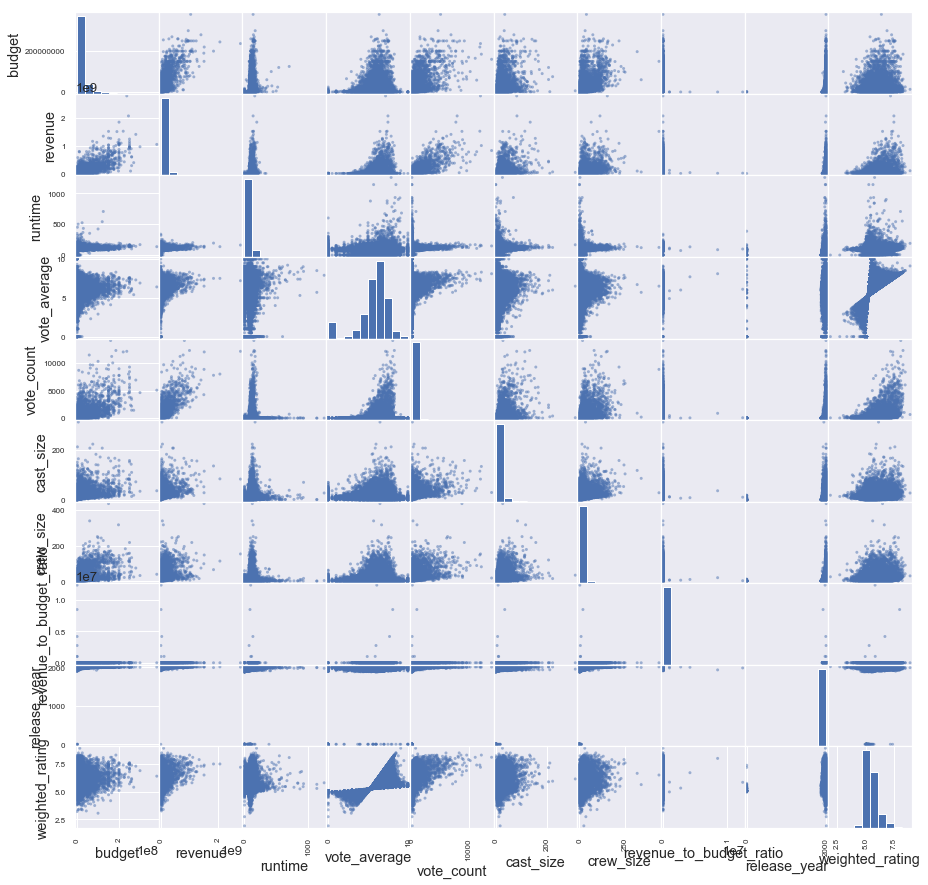

In [754]:
# Examine rating vs numerical features

from pandas.plotting import scatter_matrix

attributes = ["budget", "popularity","revenue","runtime","vote_average","vote_count","cast_size","crew_size","revenue_to_budget_ratio","release_year","weighted_rating"]
scatter_matrix(movies_reduced[attributes], figsize=(15, 15))
plt.show()

* Most of the features are correlated to some extent
* revenue_to_budget_ratio and release_year don't seem to be correlated with anything - probably can be removed

In [755]:
# remove features that don't have meaningful correlation with the revenue
movies_reduced = movies_reduced.drop(columns = 'release_year') 
movies_reduced = movies_reduced.drop(columns = 'revenue_to_budget_ratio') 

In [756]:
movies_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46628 entries, 0 to 46627
Data columns (total 10 columns):
budget             9053 non-null float64
id                 46628 non-null object
popularity         46624 non-null object
revenue            7537 non-null float64
runtime            46360 non-null float64
vote_average       46628 non-null float64
vote_count         46628 non-null float64
cast_size          46628 non-null int64
crew_size          46628 non-null int64
weighted_rating    46628 non-null float64
dtypes: float64(6), int64(2), object(2)
memory usage: 3.9+ MB


#### Adding the encoded data sets

In [757]:
movies_full = movies_reduced.copy()
movies_full.shape

(46628, 10)

In [758]:
movies_full = movies_full.join(titles_df)
movies_full.shape

(46628, 285)

In [759]:
movies_full = movies_full.join(collections_df)
movies_full.shape

(46628, 288)

In [760]:
movies_full = movies_full.join(keywords_df)
movies_full.shape

(46628, 387)

In [761]:
movies_full = movies_full.join(tagline_df)
movies_full.shape

(46628, 487)

In [762]:
movies_full = movies_full.join(overview_df)
movies_full.shape

(46628, 587)

In [763]:
movies_full = movies_full.join(spoken_languages_df)
movies_full.shape

(46628, 628)

In [764]:
movies_full = movies_full.join(original_languages_df)
movies_full.shape

(46628, 657)

In [765]:
movies_full = movies_full.join(homepage_domains_df)
movies_full.shape

(46628, 667)

In [766]:
movies_full = movies_full.join(production_companies_df)
movies_full.shape

(46628, 801)

In [767]:
movies_full = movies_full.join(production_countries_df)
movies_full.shape

(46628, 849)

In [768]:
movies_full = movies_full.join(directors_df)
movies_full.shape

(46628, 861)

In [769]:
movies_full = movies_full.join(actors_df)
movies_full.shape

(46628, 1540)

In [770]:
movies_full = movies_full.join(season_df)
movies_full.shape

(46628, 1545)

In [771]:
movies_full = movies_full.join(status_df)
movies_full.shape

(46628, 1548)

In [772]:
movies_full = movies_full.join(franchise_df)
movies_full.shape

(46628, 1549)

In [773]:
movies_full = movies_full.join(genres_df)
movies_full.shape

(46628, 1571)

In [774]:
movies_full.head(10)

,budget,id,popularity,revenue,runtime,vote_average,vote_count,cast_size,crew_size,weighted_rating,title_adventure,title_adventures,title_age,title_alone,title_am,title_america,title_american,title_angel,title_angels,title_art,title_away,title_baby,title_back,title_bad,title_battle,title_beach,title_beast,title_beautiful,title_beauty,title_best,title_big,title_black,title_blood,title_blue,title_blues,title_body,title_book,title_born,title_boy,title_boys,title_bride,title_brother,title_brothers,title_call,title_captain,title_case,title_cat,title_charlie,title_child,title_children,...,actor_william_b,actor_william_demarest,actor_william_forsythe,actor_william_h,actor_william_holden,actor_william_hurt,actor_william_sadler,actor_william_schallert,actor_william_shatner,actor_winona_ryder,actor_won,actor_woo,actor_woody_allen,actor_woody_harrelson,actor_woong,actor_xander_berkeley,actor_yeon,actor_young,actor_yu,season_autumn,season_spring,season_summer,season_unknown,season_winter,status_Post Production,status_Released,status_Rumored,franchise,gen_action,gen_adventure,gen_animation,gen_comedy,gen_crime,gen_documentary,gen_drama,gen_family,gen_fantasy,gen_fiction,gen_foreign,gen_history,gen_horror,gen_movie,gen_music,gen_mystery,gen_romance,gen_science,gen_thriller,gen_tv,gen_war,gen_western
0,30000000.0,862,21.946943,3.73554e+08,81.0,7.7,5415.0,13,106,7.68464,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,True,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,65000000.0,8844,17.015539,2.62797e+08,104.0,6.9,2413.0,26,16,6.87693,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,False,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,NaN,15602,11.7129,NaN,101.0,6.5,92.0,7,4,6.16232,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,True,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,16000000.0,31357,3.859495,8.14522e+07,127.0,6.1,34.0,10,10,5.67558,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,False,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,NaN,11862,8.387519,7.65789e+07,106.0,5.7,173.0,12,7,5.62459,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,True,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,60000000.0,949,17.924927,1.87437e+08,170.0,7.7,1886.0,65,71,7.65644,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,False,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
6,58000000.0,11860,6.677277,NaN,127.0,6.2,141.0,57,53,6.01429,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,False,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
7,NaN,45325,2.561161,NaN,97.0,5.4,45.0,7,4,5.33144,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,False,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,35000000.0,9091,5.23158,6.43502e+07,106.0,5.5,174.0,6,9,5.45749,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,False,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
9,58000000.0,710,14.686036,3.52194e+08,130.0,6.6,1194.0,20,46,6.56234,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,True,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


#### Final cleansing

In [775]:
# remove empty target values
movies_full_filtered = movies_full[movies_full['revenue'].notnull()]

In [776]:
# identify which columns have empty values
print('Empty values for budget: {}'.format(movies_full_filtered['budget'].isnull().values.any()))
print('Empty values for popularity: {}'.format(movies_full_filtered['popularity'].isnull().values.any()))
print('Empty values for runtime: {}'.format(movies_full_filtered['runtime'].isnull().values.any()))
print('Empty values for vote_average: {}'.format(movies_full_filtered['vote_average'].isnull().values.any()))
print('Empty values for vote_count: {}'.format(movies_full_filtered['vote_count'].isnull().values.any()))
print('Empty values for cast_size: {}'.format(movies_full_filtered['cast_size'].isnull().values.any()))
print('Empty values for crew_size: {}'.format(movies_full_filtered['crew_size'].isnull().values.any()))
print('Empty values for weighted_rating: {}'.format(movies_full_filtered['weighted_rating'].isnull().values.any()))

Empty values for budget: True
Empty values for popularity: False
Empty values for runtime: True
Empty values for vote_average: False
Empty values for vote_count: False
Empty values for cast_size: False
Empty values for crew_size: False
Empty values for weighted_rating: False


In [777]:
# replace NaN with mean
movies_full_filtered['budget'].fillna((movies_full_filtered['budget'].mean()), inplace=True)
movies_full_filtered['runtime'].fillna((movies_full_filtered['runtime'].mean()), inplace=True)

/Users/nisharaj/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [778]:
# get data set info
movies_full_filtered.info()
movies_full_filtered.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7537 entries, 0 to 46584
Columns: 1571 entries, budget to gen_western
dtypes: bool(1), float64(206), int64(1354), object(2), uint8(8)
memory usage: 89.9+ MB


,budget,revenue,runtime,vote_average,vote_count,cast_size,crew_size,weighted_rating,title_adventure,title_adventures,title_age,title_alone,title_am,title_america,title_american,title_angel,title_angels,title_art,title_away,title_baby,title_back,title_bad,title_battle,title_beach,title_beast,title_beautiful,title_beauty,title_best,title_big,title_black,title_blood,title_blue,title_blues,title_body,title_book,title_born,title_boy,title_boys,title_bride,title_brother,title_brothers,title_call,title_captain,title_case,title_cat,title_charlie,title_child,title_children,title_christmas,title_city,...,actor_willem_dafoe,actor_william_b,actor_william_demarest,actor_william_forsythe,actor_william_h,actor_william_holden,actor_william_hurt,actor_william_sadler,actor_william_schallert,actor_william_shatner,actor_winona_ryder,actor_won,actor_woo,actor_woody_allen,actor_woody_harrelson,actor_woong,actor_xander_berkeley,actor_yeon,actor_young,actor_yu,season_autumn,season_spring,season_summer,season_unknown,season_winter,status_Post Production,status_Released,status_Rumored,gen_action,gen_adventure,gen_animation,gen_comedy,gen_crime,gen_documentary,gen_drama,gen_family,gen_fantasy,gen_fiction,gen_foreign,gen_history,gen_horror,gen_movie,gen_music,gen_mystery,gen_romance,gen_science,gen_thriller,gen_tv,gen_war,gen_western
count,7.53700e+03,7.53700e+03,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,...,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000,7537.00000
mean,3.09810e+07,6.82172e+07,107.74386,6.21774,554.21215,21.25899,24.85525,6.03464,0.00119,0.00172,0.00146,0.00146,0.00053,0.00146,0.00597,0.00080,0.00172,0.00106,0.00172,0.00199,0.00411,0.00372,0.00159,0.00027,0.00080,0.00119,0.00172,0.00265,0.00597,0.00650,0.00252,0.00318,0.00093,0.00146,0.00172,0.00106,0.00345,0.00252,0.00133,0.00093,0.00119,0.00093,0.00133,0.00040,0.00106,0.00119,0.00146,0.00146,0.00239,0.00464,...,0.00730,0.00119,0.00027,0.00186,0.00743,0.00119,0.00385,0.00226,0.00066,0.00226,0.00345,0.00186,0.00239,0.00332,0.00597,0.00066,0.00345,0.00146,0.00358,0.00040,0.25381,0.22874,0.28990,0.00013,0.22741,0.00066,0.99828,0.00080,0.23325,0.15271,0.05400,0.35080,0.14634,0.02999,0.49914,0.09288,0.08584,0.10176,0.01141,0.03980,0.09805,0.00013,0.03582,0.07324,0.19398,0.10176,0.25275,0.00013,0.03357,0.01566
std,3.40702e+07,1.45894e+08,21.43844,1.02630,1099.87957,18.79332,30.03915,0.75541,0.03454,0.04150,0.03818,0.03818,0.02303,0.03818,0.07704,0.02821,0.04150,0.03256,0.04150,0.04457,0.06401,0.06084,0.03987,0.01629,0.02821,0.03454,0.04150,0.05145,0.07704,0.08037,0.05015,0.05634,0.03046,0.03818,0.04150,0.03256,0.05864,0.05015,0.03640,0.03046,0.03454,0.03046,0.03640,0.01995,0.03256,0.03454,0.03818,0.03818,0.04881,0.06799,...,0.08512,0.03454,0.01629,0.04306,0.08588,0.03454,0.06191,0.04744,0.02575,0.04744,0.05864,0.05148,0.05398,0.05750,0.07704,0.02575,0.05864,0.03818,0.06404,0.01995,0.43522,0.42005,0.45375,0.01152,0.41919,0.02575,0.04150,0.02821,0.42293,0.35973,0.22603,0.47725,0.35347,0.17056,0.50003,0.29028,0.28015,0.30236,0.10622,0.1

#### Review and Save Enhanced Dataset

In [779]:
# copy the final feature set to movies
movies = movies_full_filtered.copy()

# verify the schema and data end results

movies.name = 'movies'
quick_schema_analysis(movies)
quick_data_analysis(movies)

Basic Schema Analysis for dataframe=movies
************************************************
Rows and Columns:
(7537, 1571)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7537 entries, 0 to 46584
Columns: 1571 entries, budget to gen_western
dtypes: bool(1), float64(206), int64(1354), object(2), uint8(8)
memory usage: 89.9+ MB
None


Null Values - percentage:
budget                     0.0
id                         0.0
popularity                 0.0
revenue                    0.0
runtime                    0.0
vote_average               0.0
vote_count                 0.0
cast_size                  0.0
crew_size                  0.0
weighted_rating            0.0
title_adventure            0.0
title_adventures           0.0
title_age                  0.0
title_alone                0.0
title_am                   0.0
title_america              0.0
title_american             0.0
title_angel                0.0
title_angels               0.0
title_art                  0.0
title_away       

In [780]:
# save movies dataframe to a csv
                    
movies_final_file = os.path.join(PROJECT_LOCAL_DIR, 'movies_final.csv')

print('Saving final model to ' + movies_final_file + '...')

movies.to_csv(movies_final_file,
              encoding='utf-8',
              index=False
              )

print('Model saved.')

Saving final model to movies/movies_final.csv...
Model saved.


## Feature selction and reduction - continued

In [781]:
movies_model = movies_full_filtered.copy().drop('id',axis=1)

In [782]:
# define target value and features
target = 'revenue'
features = list(movies_model.columns)
features = [f for f in features if f!=target]

feature_set = movies_model[features]
target_col = movies_model[target]

#### prepare the train and test data sets

In [783]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(movies_model, test_size=0.3)

X_tr = train_set[features]
y_tr = train_set[[target]]

X_te = test_set[features]
y_te = test_set[[target]]

#add a new target variable for classification 

y_tr_cl = np.ravel(y_tr)/np.ravel(train_set.budget)>2.50
y_te_cl = np.ravel(y_te)/np.ravel(test_set.budget)>2.50

#### SelectKBest with chi square

In [784]:
# Import the necessary libraries first
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [785]:
# define the select K best model - using chi square
select_best = SelectKBest(score_func=chi2)

In [786]:
# identify the best hyper parameter
from sklearn.linear_model import LinearRegression

k_arr = [10, 20, 30, 40 ,50, 75, 100]

for k in k_arr:
    select_best.k = k
    select_best.fit(np.asarray(X_tr),np.asarray(y_tr, dtype="|S100"))
    X_tr_new = select_best.transform(X_tr)
    X_te_new = select_best.transform(X_te)
    print("\n")
    print("Performance for k={}".format(k))
    print("Trainng set:")
    lin_scores = cross_val_score(LinearRegression(), X_tr_new, y_tr, scoring="neg_mean_squared_error", cv=4)
    lin_rmse_scores = np.sqrt(-lin_scores)
    display_scores(lin_rmse_scores)
    print("Test set:")
    lin_scores = cross_val_score(LinearRegression(), X_te_new, y_te, scoring="neg_mean_squared_error", cv=4)
    lin_rmse_scores = np.sqrt(-lin_scores)
    display_scores(lin_rmse_scores)

/Users/nisharaj/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:167: RuntimeWarning: divide by zero encountered in true_divide
  chisq /= f_exp




Performance for k=10
Trainng set:
Scores: [77896596.92493302 63063342.40403547 76080150.81770514 80909889.68361408]
Mean: 74487494.95757192
Test set:
Scores: [8.62815740e+07 7.79652781e+07 1.11558986e+08 7.09205130e+07]
Mean: 86681587.8635212


/Users/nisharaj/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:167: RuntimeWarning: divide by zero encountered in true_divide
  chisq /= f_exp




Performance for k=20
Trainng set:
Scores: [78106207.40262638 63181306.40832767 76137663.70481822 81474928.63061126]
Mean: 74725026.53659588
Test set:
Scores: [8.63069953e+07 7.82821833e+07 1.11724510e+08 7.09382242e+07]
Mean: 86812978.10073471


/Users/nisharaj/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:167: RuntimeWarning: divide by zero encountered in true_divide
  chisq /= f_exp




Performance for k=30
Trainng set:
Scores: [78523822.21885781 63658907.27354717 76161174.27389936 83290258.09944363]
Mean: 75408540.466437
Test set:
Scores: [8.73721451e+07 7.82218524e+07 1.11229804e+08 7.11412709e+07]
Mean: 86991268.18651101


/Users/nisharaj/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:167: RuntimeWarning: divide by zero encountered in true_divide
  chisq /= f_exp




Performance for k=40
Trainng set:
Scores: [79102717.89300586 63644428.4314559  75889927.26660916 83085907.18161012]
Mean: 75430745.19317026
Test set:
Scores: [8.77873067e+07 7.73531849e+07 1.12872673e+08 7.12259956e+07]
Mean: 87309789.98246434


/Users/nisharaj/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:167: RuntimeWarning: divide by zero encountered in true_divide
  chisq /= f_exp




Performance for k=50
Trainng set:
Scores: [79079924.35335836 63401277.1513553  75720109.29175362 83437341.72876756]
Mean: 75409663.1313087
Test set:
Scores: [8.74928599e+07 7.74626584e+07 1.12883077e+08 7.16604050e+07]
Mean: 87374749.93728584


/Users/nisharaj/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:167: RuntimeWarning: divide by zero encountered in true_divide
  chisq /= f_exp




Performance for k=75
Trainng set:
Scores: [79036772.47412722 63384546.09803759 75733153.71106553 84469623.77321845]
Mean: 75656024.0141122
Test set:
Scores: [8.69992559e+07 7.74372228e+07 1.10655953e+08 7.27398922e+07]
Mean: 86958081.05213505


/Users/nisharaj/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:167: RuntimeWarning: divide by zero encountered in true_divide
  chisq /= f_exp




Performance for k=100
Trainng set:
Scores: [79116675.89254159 63527582.04754704 75800191.56329857 84621405.81028499]
Mean: 75766463.82841805
Test set:
Scores: [8.69981942e+07 7.74083733e+07 1.07570425e+08 7.35468619e+07]
Mean: 86380963.54877457


In [787]:
# pick the best : for k=40
select_best.k = 40
select_best.fit(np.asarray(X_tr),np.asarray(y_tr, dtype="|S100"))
X_tr = select_best.transform(X_tr)
X_te = select_best.transform(X_te)

/Users/nisharaj/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:167: RuntimeWarning: divide by zero encountered in true_divide
  chisq /= f_exp


#### Scaling

In [788]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_tr)
X_tr = scaler.transform(X_tr)
X_te = scaler.transform(X_te)

/Users/nisharaj/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/nisharaj/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/nisharaj/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


#### Feature tuning pipeline (using linear regression)

In [789]:
# Linear regression and pipeline (to evaluate feature selection and reduction)
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

steps = [('regression',LinearRegression())]
pipeline = Pipeline(steps)

#### PCA

In [790]:
from sklearn.decomposition import PCA
# Make an instance of the Model
pca = PCA()

In [791]:
# add to the steps collection
pipeline.steps.insert(0,('pca',pca))

In [792]:
# GridSearchCV
parameters = {}
grid_search = GridSearchCV(pipeline,parameters, cv=4, scoring='neg_mean_squared_error')

In [793]:
# add corresponding parameters
grid_search.param_grid['pca__n_components'] = [0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,0.999,1]

In [794]:
# fit the model
grid_search.fit(X_tr,y_tr)

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('regression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'pca__n_components': [0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 0.999, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [795]:
# training scores
print("Best pca parameter is {}".format(grid_search.best_params_))
lin_scores = grid_search.best_score_
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Best pca parameter is {'pca__n_components': 0.99}
Scores: 75719904.99643789
Mean: 75719904.99643789


In [796]:
# run best model with test data
grid_search_final = grid_search.best_estimator_ 
grid_search_final.fit(X_te,y_te)
lin_scores = cross_val_score(grid_search_final, X_te, y_te, scoring="neg_mean_squared_error", cv=4)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [8.78534172e+07 7.75664130e+07 1.03467270e+08 7.11946262e+07]
Mean: 85020431.60048997


In [797]:
# apply tranformaiton to the features
pca.n_components = 0.999
pca.fit(X_tr)
X_tr = pca.transform(X_tr)
X_te = pca.transform(X_te)

# check the number of principal components
print(pca.n_components_)

40


In [798]:
# tidy up - remove the pca step from the pipeline
del pipeline.steps[0]

#### Clustering - K-means

In [799]:
from sklearn.cluster import KMeans
kmeans = KMeans()

In [800]:
# add to the steps collection
pipeline.steps.insert(0,('kmeans',kmeans))

In [801]:
# GridSearchCV
parameters = {}
grid_search = GridSearchCV(pipeline,parameters, cv=4, scoring='neg_mean_squared_error')

# add corresponding parameters
grid_search.param_grid['kmeans__n_clusters'] = [2,4,6,8,10,15,20,30,40]

In [802]:
# fit the model
grid_search.fit(X_tr,y_tr)

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('kmeans', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)), ('regression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kmeans__n_clusters': [2, 4, 6, 8, 10, 15, 20, 30, 40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [803]:
# training set scores
print("Best k-means parameter is {}".format(grid_search.best_params_))
lin_scores = grid_search.best_score_
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Best k-means parameter is {'kmeans__n_clusters': 40}
Scores: 88235071.91970293
Mean: 88235071.91970293


In [804]:
# try with test data
grid_search_final = grid_search.best_estimator_ 
grid_search_final.fit(X_te,y_te)
lin_scores = cross_val_score(grid_search_final, X_te, y_te, scoring="neg_mean_squared_error", cv=4)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [9.71091121e+07 8.28916409e+07 1.45116889e+08 8.81702030e+07]
Mean: 103321961.22219995


**Conclusion** : results don't improve. Skip clustering

# 4.0 Model 

## Reasons for considering a classification model in addition to the regression model.

Box Office profits are a function of production budgets, ticket prices & Marketing/ Distribution costs based on their year of release.


Hence, while evaluating historical values, profit calculations without accounting for inflation doesnt always provide the big picture (pun intended). A recommended option is arriving at a revenue to budget ratio (R/B), which offers better insights compared to revenue recognition alone. 

Further, this ratio is also useful in determining the relative success of a theatrical release. The total cost of movie production is not limited to production budgets but should take into account the distribution and marketing costs which is increasingly becoming important. Accordingly, movie producers and industry watchers now believe that a movie needs to make in excess of 2.5 times its production budget even to be considered a moderate success.

Hence, the classifier feature matrix can drop the 'revenue' and 'revenue to budget ratio' as new unseen data ( data on movies that are yet to be released which we want to know whether will be a success or failure) will not have a revenue column. The attempt here is to predict film success using features like genre, production company, month/season of release, cast/crew size, country of production, whether part of a franchise, weighted rating etc. These are parameters that are already known before the movie's release.


## Classification

### 1. Logistic Regression

In [805]:
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression()
params_logreg={'C':np.logspace(-5, 8, 15)}
logreg_cv = GridSearchCV(logreg,params_logreg,cv=4)
logreg_cv.fit(X_tr,y_tr_cl)

/Users/nisharaj/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nisharaj/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nisharaj/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nisharaj/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nisharaj/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be ch

/Users/nisharaj/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nisharaj/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nisharaj/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nisharaj/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nisharaj/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be ch

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([1.00000e-05, 8.48343e-05, 7.19686e-04, 6.10540e-03, 5.17947e-02,
       4.39397e-01, 3.72759e+00, 3.16228e+01, 2.68270e+02, 2.27585e+03,
       1.93070e+04, 1.63789e+05, 1.38950e+06, 1.17877e+07, 1.00000e+08])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [806]:
print('Accuracy: ',logreg_cv.best_score_)

Accuracy:  0.7747867298578199


### 2. Random Forest

In [807]:
forest=RandomForestClassifier(random_state=42)
params_forest = {'n_estimators': [3, 4, 6, 7, 10, 20, 50, 100]}
forest_cv=GridSearchCV(forest, params_forest,cv=4)
forest_cv.fit(X_tr,y_tr_cl)
print('Accuracy: ',forest_cv.best_score_)

Accuracy:  0.769478672985782


### 3. KNN

In [808]:
knn=KNeighborsClassifier()
params_knn = {'n_neighbors': [3, 5, 10, 20]}
knn_cv=GridSearchCV(knn, params_knn,cv=4,n_jobs=-1)
knn_cv.fit(X_tr,y_tr_cl)

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_neighbors': [3, 5, 10, 20]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [809]:
print('Accuracy:',knn_cv.best_score_)

Accuracy: 0.7577251184834123


### 4. Decision tree

In [810]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()
params_tree = {"criterion": ["gini", "entropy"],"min_samples_split": [2, 10, 20],"max_depth": [None, 2, 5, 10],
              "min_samples_leaf": [1, 5, 10],"max_leaf_nodes": [None, 5, 10, 20]
              }
tree_cv=GridSearchCV(tree, params_tree,cv=4,n_jobs=-1)
tree_cv.fit(X_tr,y_tr_cl)


GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'criterion': ['gini', 'entropy'], 'min_samples_split': [2, 10, 20], 'max_depth': [None, 2, 5, 10], 'min_samples_leaf': [1, 5, 10], 'max_leaf_nodes': [None, 5, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [811]:
print('Accuracy:',tree_cv.best_score_)

Accuracy: 0.7692890995260664


### 5. AdaBoostClassifier with DecisionTree as base estimator

In [812]:
from sklearn.ensemble import AdaBoostClassifier
ABC= AdaBoostClassifier(base_estimator=tree_cv.best_estimator_,n_estimators=100)
np.mean(cross_val_score(ABC, X_tr, y_tr_cl, cv=3))

0.7399026218416083

### 6. Voting Classifier 

In [813]:
from sklearn.ensemble import VotingClassifier
classifiers = [('Logistic Regression', logreg_cv.best_estimator_),('K Nearest Neighbours', knn_cv.best_estimator_),
               ('RandomForestClassifier', forest_cv.best_estimator_),('DecisionTreeClassifier',tree_cv.best_estimator_)]

vc = VotingClassifier(estimators=classifiers)

print('Accuracy: ',np.mean(cross_val_score(vc, X_tr, y_tr_cl, cv=3)))

/Users/nisharaj/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nisharaj/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nisharaj/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy:  0.7745945749474555


## Regression

### 1. Linear Regression

In [814]:
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
lin_reg=LinearRegression()
lin_scores = cross_val_score(lin_reg,X_tr,y_tr, scoring="neg_mean_squared_error", cv=4)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)


Scores: [79102717.89388901 63644428.43257346 75889927.26664469 83085907.1816179 ]
Mean: 75430745.19368127


### 2. Ridge Regression

In [815]:
from sklearn.linear_model import Ridge
param_grid = [{'alpha': [0.001,0.01,0.1,1,10,100,1000,1000]}]
rr_cv = GridSearchCV(Ridge(), param_grid, cv=4, scoring='neg_mean_squared_error')
rr_cv.fit(X_tr, y_tr)

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [816]:
print(np.sqrt(-rr_cv.best_score_))

75707639.9468251


### 3. Lasso Regression

In [817]:
from sklearn.linear_model import Lasso
param_grid = [{'alpha': [0.001,0.01,0.1,1,10,100,1000,1000]}]
lr_cv = GridSearchCV(Lasso(), param_grid, cv=3, scoring='neg_mean_squared_error')
lr_cv.fit(X_tr, y_tr)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [818]:
print(np.sqrt(-lr_cv.best_score_))

75534405.3397189


## Test

#### Classification

In [819]:
from sklearn.metrics import accuracy_score

final_cl_model = logreg_cv.best_estimator_  
y_pred_cl = final_cl_model.predict(X_te)

print('Accuracy score: ',accuracy_score(y_te_cl,y_pred_cl))

Accuracy score:  0.7683465959328029


**Logistic Regression has a train accuracy of 0.769 and a test accuracy of 0.782**

#### Regression

In [820]:
from sklearn.metrics import mean_squared_error

final_reg_model = lin_reg
final_reg_model.fit(X_tr,y_tr)

y_pred_reg = final_reg_model.predict(X_te)

final_mse = mean_squared_error(y_te, y_pred_reg)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

84233680.08209528


## Model Evaluation 

### Best model - Logistic Regression

#### Confusion Matrix

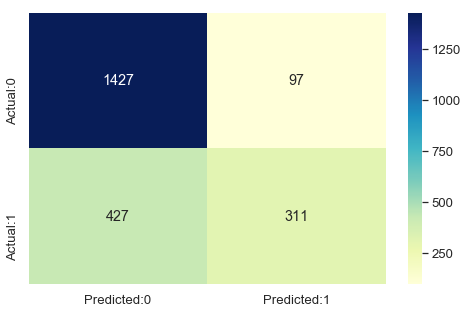

In [821]:
def cm_heatmap(y_test,y_pred):
    cm=confusion_matrix(y_test,y_pred)
    conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
    plt.figure(figsize = (8,5))
    sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

    
cm_heatmap(y_te_cl,y_pred_cl)

#### Classification report

In [822]:
print(classification_report(y_te_cl, y_pred_cl))

              precision    recall  f1-score   support

       False       0.77      0.94      0.84      1524
        True       0.76      0.42      0.54       738

   micro avg       0.77      0.77      0.77      2262
   macro avg       0.77      0.68      0.69      2262
weighted avg       0.77      0.77      0.75      2262



#### ROC Curve and AUC

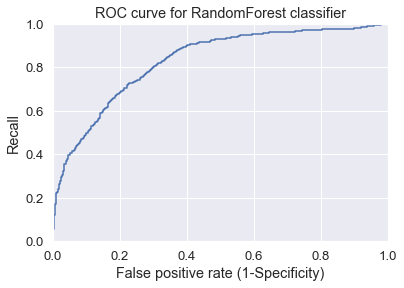

In [823]:
fpr, tpr, thresholds = roc_curve(y_te_cl, final_cl_model.predict_proba(X_te)[:,1])
plt.plot(fpr,tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for RandomForest classifier')
plt.xlabel('False positive rate (1-Specificity)')
plt.ylabel('Recall')
plt.grid(True)

In [824]:
print ("Area under the curve is ", roc_auc_score(y_te_cl,final_cl_model.predict_proba(X_te)[:,1]))

Area under the curve is  0.8307122178833336


### Evaluation of second best model

In [825]:
## Test
y_pred_forest = forest_cv.predict(X_te)
print('Accuracy score: ',accuracy_score(y_te_cl,y_pred_forest))

Accuracy score:  0.7723253757736517


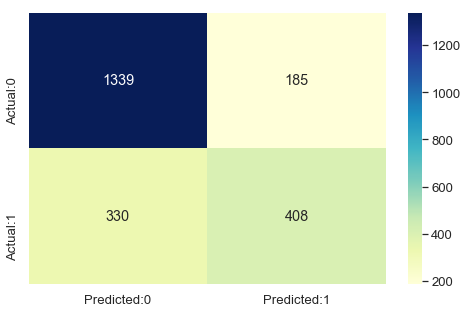

In [826]:
## Confusion matrix
cm_heatmap(y_te_cl,y_pred_forest)

In [827]:
print(classification_report(y_te_cl, y_pred_forest))

              precision    recall  f1-score   support

       False       0.80      0.88      0.84      1524
        True       0.69      0.55      0.61       738

   micro avg       0.77      0.77      0.77      2262
   macro avg       0.75      0.72      0.73      2262
weighted avg       0.77      0.77      0.77      2262



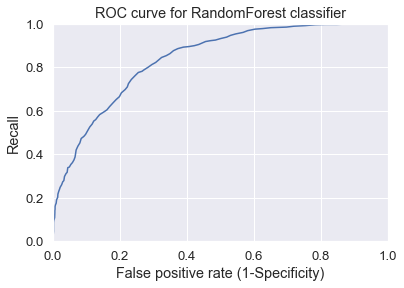

In [828]:
fpr, tpr, thresholds = roc_curve(y_te_cl, forest_cv.predict_proba(X_te)[:,1])
plt.plot(fpr,tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for RandomForest classifier')
plt.xlabel('False positive rate (1-Specificity)')
plt.ylabel('Recall')
plt.grid(True)

In [829]:
print ("Area under the curve is ", roc_auc_score(y_te_cl,forest_cv.predict_proba(X_te)[:,1]))

Area under the curve is  0.8389014254315771


### Comparision of Accuracy, Precision and Recall between Logistic Regression and Random Forest classifiers

In the case of movie box office prediction, a **high recall** translates to missing to identify a film that will be successful and  **high precision** ensures the majority of positively predicted films will be successful. 

As the average cost involved in producing a major studio film is extremely high and the number of films produced by a production house is relatively low, it is important that the classifier's positive predictions are going to be successful. Failing that will result in huge loss for the production house.  Hence a model that has high precision rather than high recall is preferred. 

In [830]:
def metrics_comp(y_te_cl,y_pred_cl,y_pred_forest):
    metrics=pd.DataFrame(index=['Accuracy','Precision','Recall'],columns=['Logistic Regression','Random Forest'])
    metrics.loc['Accuracy','Logistic Regression']=accuracy_score(y_te_cl,y_pred_cl)
    metrics.loc['Precision','Logistic Regression']=precision_score(y_te_cl,y_pred_cl)
    metrics.loc['Recall','Logistic Regression']=recall_score(y_te_cl,y_pred_cl)
    metrics.loc['Accuracy','Random Forest']=accuracy_score(y_te_cl,y_pred_forest)
    metrics.loc['Precision','Random Forest']=precision_score(y_te_cl,y_pred_forest)
    metrics.loc['Recall','Random Forest']=recall_score(y_te_cl,y_pred_forest)
    return(metrics)

In [831]:
metrics_comp(y_te_cl,y_pred_cl,y_pred_forest)

,Logistic Regression,Random Forest
Accuracy,0.76835,0.77233
Precision,0.76225,0.68803
Recall,0.42141,0.55285


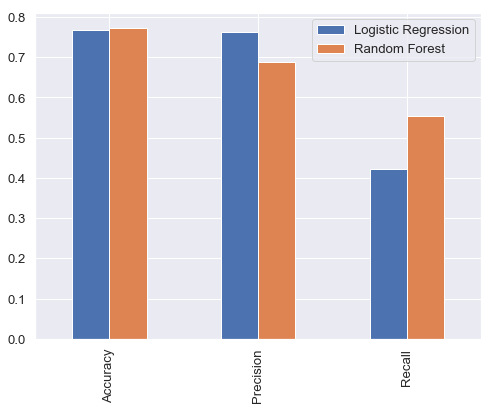

In [832]:
fig,ax=plt.subplots(figsize=(8,6))
metrics_comp(y_te_cl,y_pred_cl,y_pred_forest).plot(kind='bar',ax=ax)
plt.show()

Accuracy levels are consistant between both models. However, Logistic regression has higher precision than Random forest.

### Tradeoff between precision and recall at different thresholds.

In [833]:
precision_logreg, recall_logreg, thresholds_logreg=precision_recall_curve(y_te_cl,final_cl_model.predict_proba(X_te)[:,1])


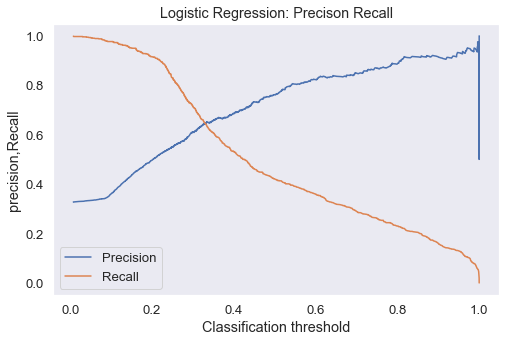

In [834]:
def p_r_threshold(thresholds,precision,recall):

    fig,ax=plt.subplots(figsize=(8,5))
    ax.plot(thresholds_logreg,precision_logreg[1:],label='Precision')
    ax.plot(thresholds_logreg,recall_logreg[1:],label='Recall')
    ax.set_xlabel('Classification threshold')
    ax.set_ylabel('precision,Recall')
    ax.set_title('Logistic Regression: Precison Recall')
    ax.legend()
    ax.grid();
p_r_threshold(thresholds_logreg,precision_logreg,recall_logreg)

At threshold 0.5 the recall is 0.4 with a very high precision (0.7). Moving the threshold to 0.6 results in a much higher precision (0.8) without a significant drop in recall.

# 5.0 Analysis

## Plots

## Scoring

# 6.0 Summary

## Observations

## Conclusions